In [242]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.stats as stats

## Etude complète 
sans les colonnes 'LYMp', 'NEUTp', 'LYMn', 'NEUTn', 'HCT', 'PCT' \
sans les étiquettes Other microcytic anemia, Leukemia, Leukemia with thrombocytopenia, Macrocytic anemia


In [243]:
df = pd.read_csv('../dataset/diagnosed_cbc_data_v4.csv')
df.head()

WBC  LYMp  NEUTp  LYMn  NEUTn   RBC  HGB    HCT   MCV   MCH  MCHC    PLT  \
0  10.0  43.2   50.1   4.3    5.0  2.77  7.3   24.2  87.7  26.3  30.1  189.0   
1  10.0  42.4   52.3   4.2    5.3  2.84  7.3   25.0  88.2  25.7  20.2  180.0   
2   7.2  30.7   60.7   2.2    4.4  3.97  9.0   30.5  77.0  22.6  29.5  148.0   
3   6.0  30.2   63.5   1.8    3.8  4.22  3.8   32.8  77.9  23.2  29.8  143.0   
4   4.2  39.1   53.7   1.6    2.3  3.93  0.4  316.0  80.6  23.9  29.7  236.0   

    PDW   PCT                      Diagnosis  
0  12.5  0.17  Normocytic hypochromic anemia  
1  12.5  0.16  Normocytic hypochromic anemia  
2  14.3  0.14         Iron deficiency anemia  
3  11.3  0.12         Iron deficiency anemia  
4  12.8  0.22  Normocytic hypochromic anemia

In [244]:
df.dtypes

WBC          float64
LYMp         float64
NEUTp        float64
LYMn         float64
NEUTn        float64
RBC          float64
HGB          float64
HCT          float64
MCV          float64
MCH          float64
MCHC         float64
PLT          float64
PDW          float64
PCT          float64
Diagnosis     object
dtype: object

In [245]:
string_col = df.select_dtypes(include="object").columns
df[string_col]=df[string_col].astype("string")

In [246]:
df.dtypes

WBC                 float64
LYMp                float64
NEUTp               float64
LYMn                float64
NEUTn               float64
RBC                 float64
HGB                 float64
HCT                 float64
MCV                 float64
MCH                 float64
MCHC                float64
PLT                 float64
PDW                 float64
PCT                 float64
Diagnosis    string[python]
dtype: object

on convertis les colonnes objet en string pour qu'on puisse travailler avec

In [247]:
string_col=df.select_dtypes("string").columns.to_list()

num_col=df.columns.to_list()
#print(num_col)
for col in string_col:
    num_col.remove(col)
df.describe().T

count        mean         std    min        25%         50%  \
WBC    1281.0    7.862717    3.564466   0.80    6.00000    7.400000   
LYMp   1281.0   25.845000    7.038728   6.20   25.84500   25.845000   
NEUTp  1281.0   77.511000  147.746273   0.70   71.10000   77.511000   
LYMn   1281.0    1.880760    1.335689   0.20    1.88076    1.880760   
NEUTn  1281.0    5.140940    2.872294   0.50    5.10000    5.140940   
RBC    1281.0    4.708267    2.817200   1.36    4.19000    4.600000   
HGB    1281.0   12.184551    3.812897 -10.00   10.80000   12.300000   
HCT    1281.0   46.152600  104.886100   2.00   39.20000   46.152600   
MCV    1281.0   85.793919   27.177663 -79.30   81.20000   86.600000   
MCH    1281.0   32.084840  111.170756  10.90   25.50000   27.800000   
MCHC   1281.0   31.739149    3.300352  11.50   30.60000   32.000000   
PLT    1281.0  229.981421   93.019336  10.00  157.00000  213.000000   
PDW    1281.0   14.312512    3.005079   8.40   13.30000   14.312512   
PCT    1281.0    0.260280    0.685351   0.01    0.17000    0.260280   

             75%     max  
WBC      8.68000    45.7  
LYMp    25.84500    91.4  
NEUTp   77.51100  5317.0  
LYMn     1.88076    41.8  
NEUTn    5.14094    79.0  
RBC      5.10000    90.8  
HGB     13.50000    87.1  
HCT     46.15260  3715.0  
MCV     90.20000   990.0  
MCH     29.60000  3117.0  
MCHC    32.90000    92.8  
PLT    293.00000   660.0  
PDW     14.70000    97.0  
PCT      0.26028    13.6

In [248]:
#ajout de la colonne IsSick
df['IsSick'] = df['Diagnosis'].apply(lambda x: 0 if x == 'Healthy' else 1)
#pour cette première étude on enleve les colonnes LYMp, NEUTp, LYMn, NEUTn, HCT, PCT car elles sont difficilement exploitables
df = df.drop(['LYMp', 'NEUTp', 'LYMn', 'NEUTn', 'HCT', 'PCT', 'PDW'], axis=1)
#de plus on enleves tous les individu qui ont un diagnostic qui a une trop petite population pour être significatif
df = df[df.Diagnosis != 'Other microcytic anemia']
df = df[df.Diagnosis != 'Leukemia']
df = df[df.Diagnosis != 'Leukemia with thrombocytopenia']
df = df[df.Diagnosis != 'Macrocytic anemia']


In [249]:
#afficher le nombre d'individu total
df.shape[0]

1146

<Axes: xlabel='diagnosis_init', ylabel='count'>

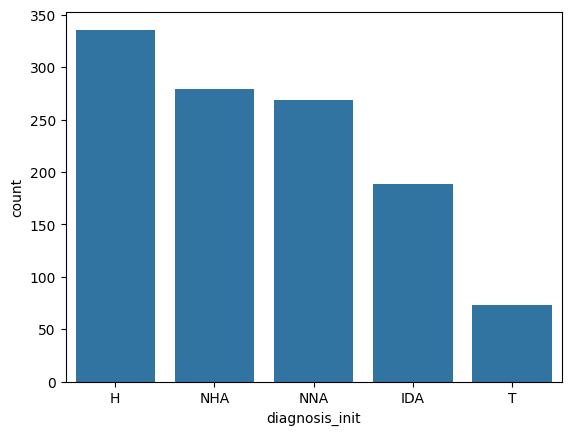

In [250]:
#visualisation univariée
#ajout de la colonne Diagnosis initial pour la visualisation
df['diagnosis_init'] = df['Diagnosis'].apply(lambda x: ''.join([word[0].upper() for word in x.split()]))
#conter le nombre par diagnostic
sns.barplot(x=df['diagnosis_init'].value_counts().index, y=df['diagnosis_init'].value_counts())

<Axes: xlabel='IsSick', ylabel='count'>

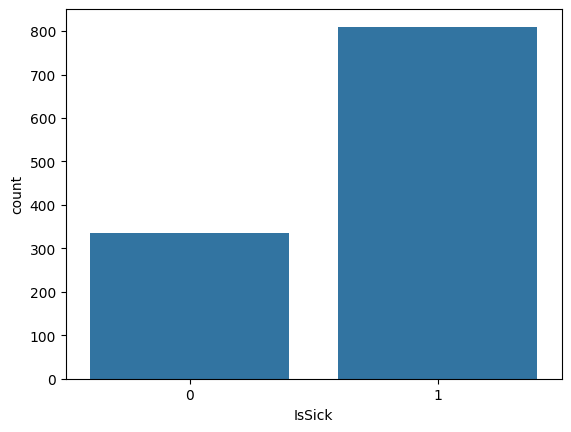

In [251]:
#compter le nombre de malade et de sain
sns.barplot(x=df['IsSick'].value_counts().index, y=df['IsSick'].value_counts())

[]

<Figure size 1500x1000 with 0 Axes>

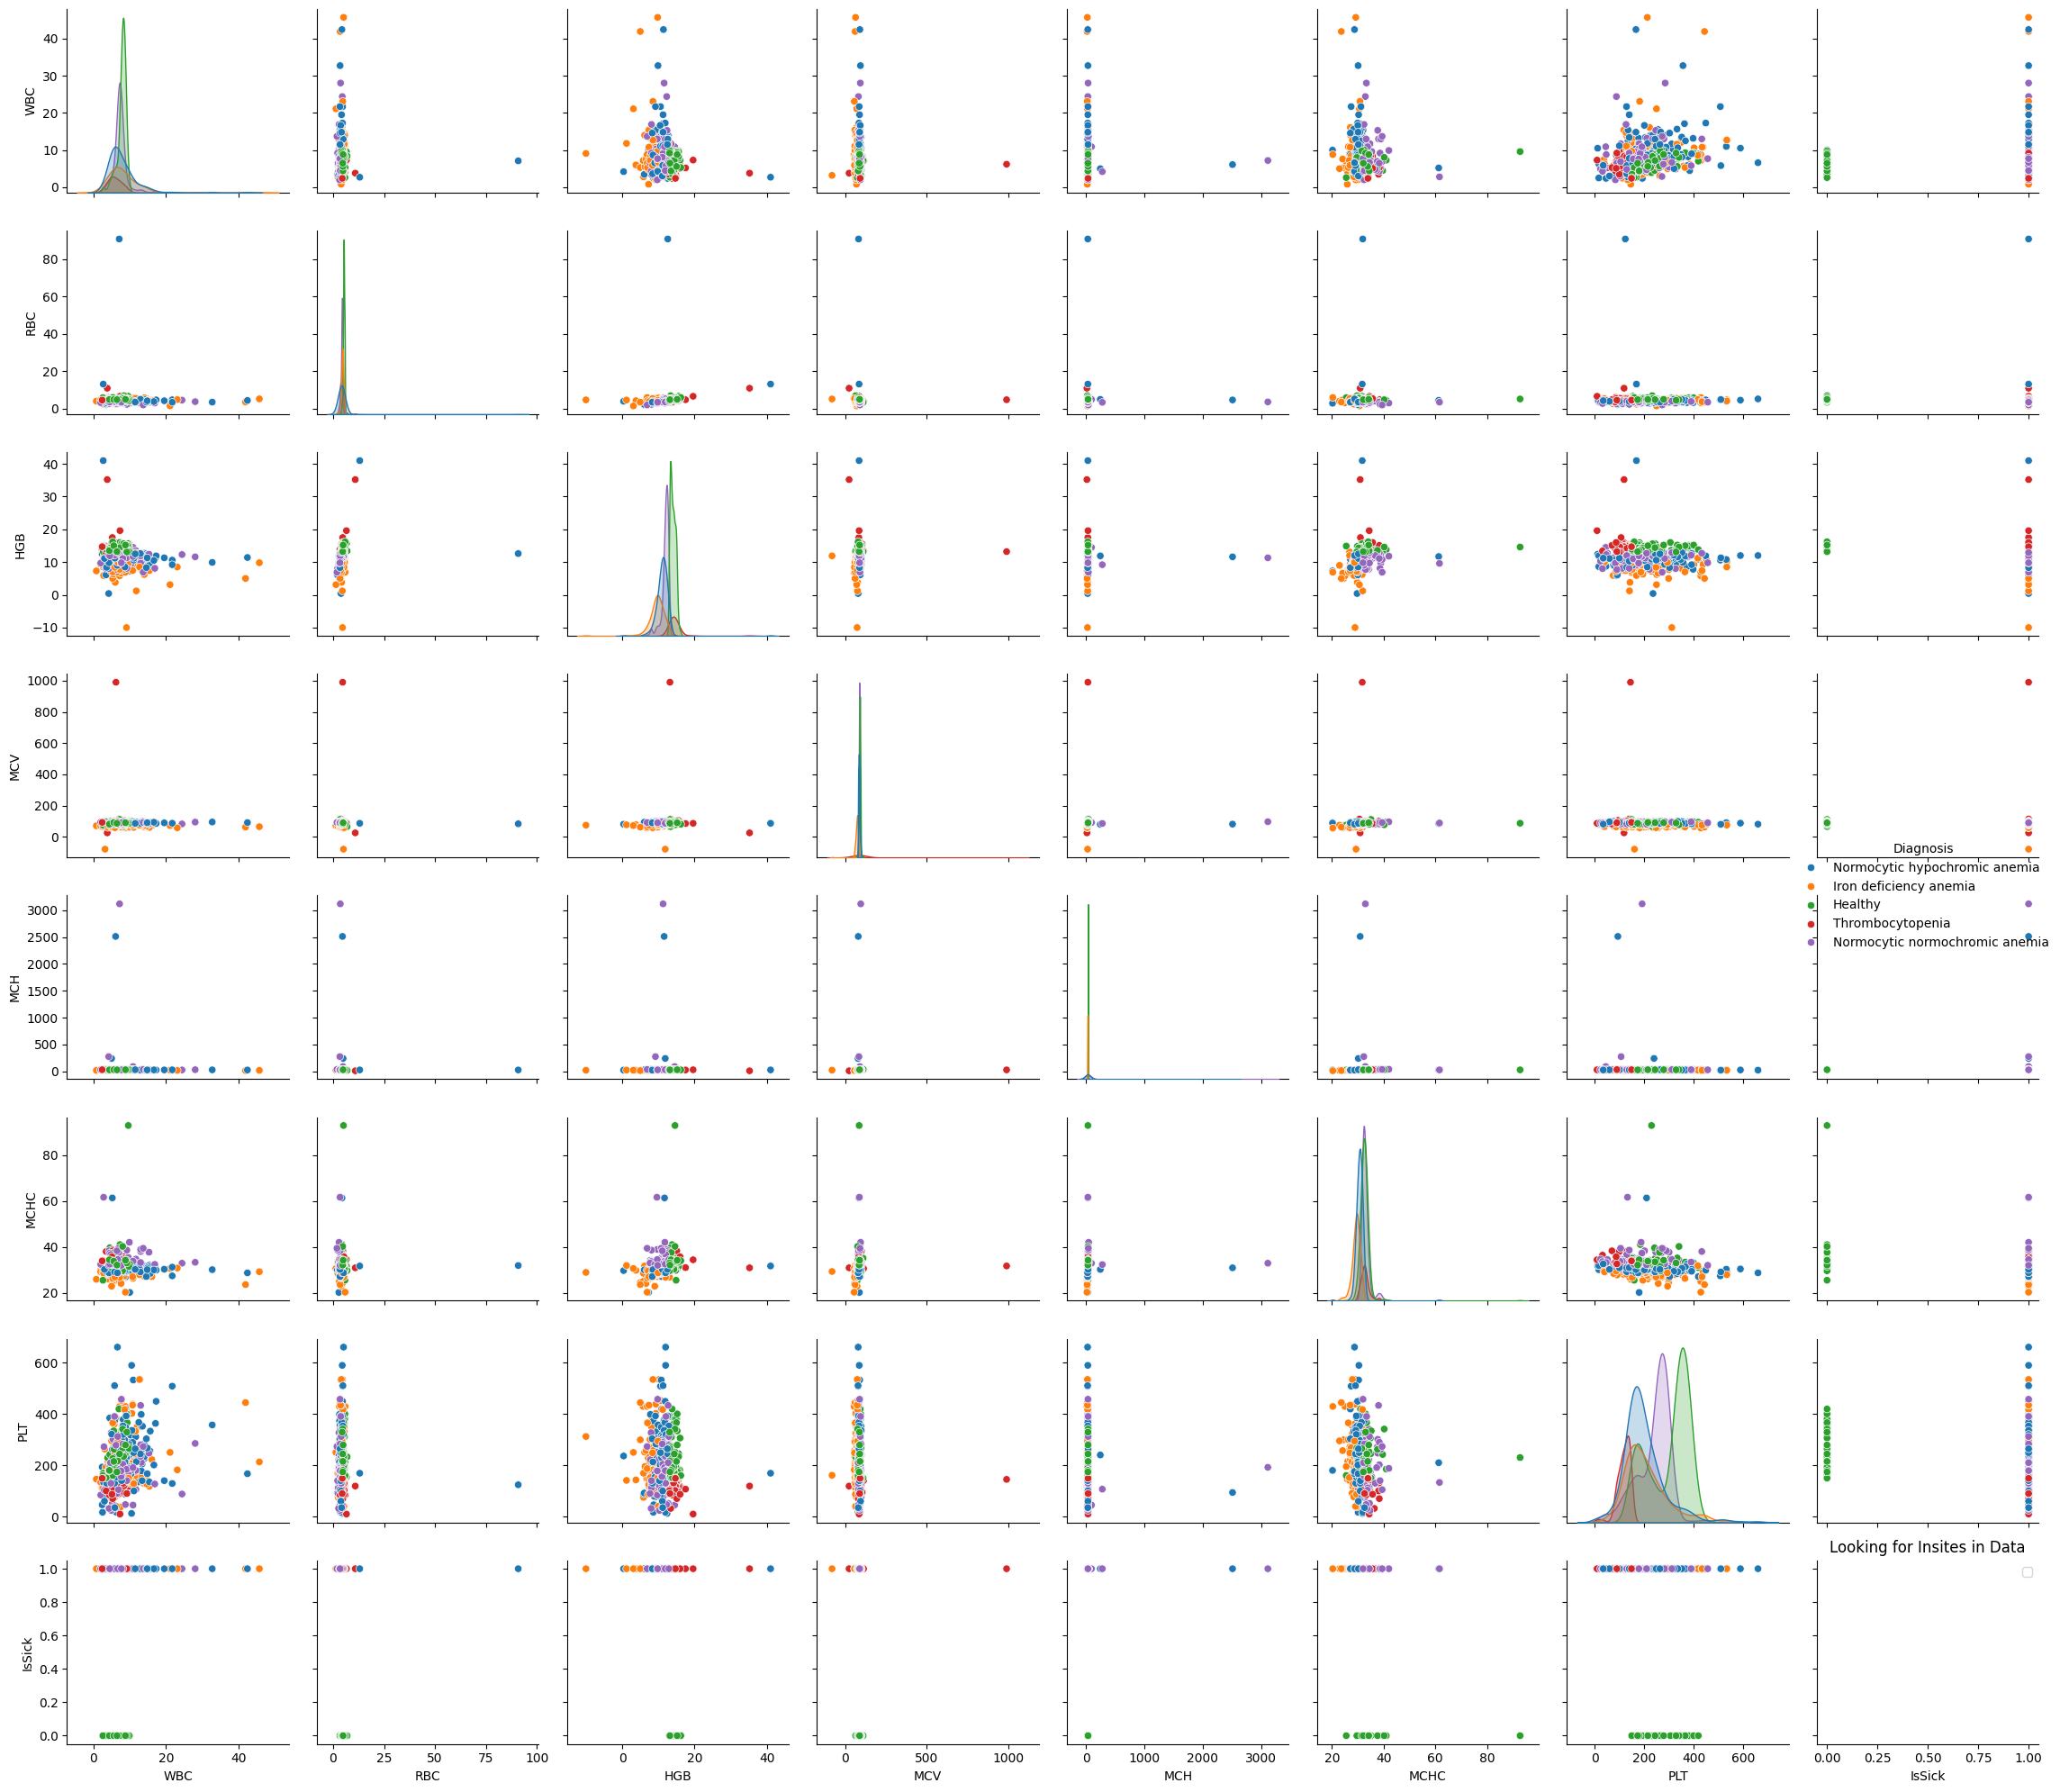

In [252]:
plt.figure(figsize=(15,10))
sns.pairplot(df,hue="Diagnosis")
plt.title("Looking for Insites in Data")
plt.legend("Diagnosis")
plt.tight_layout()
plt.plot()

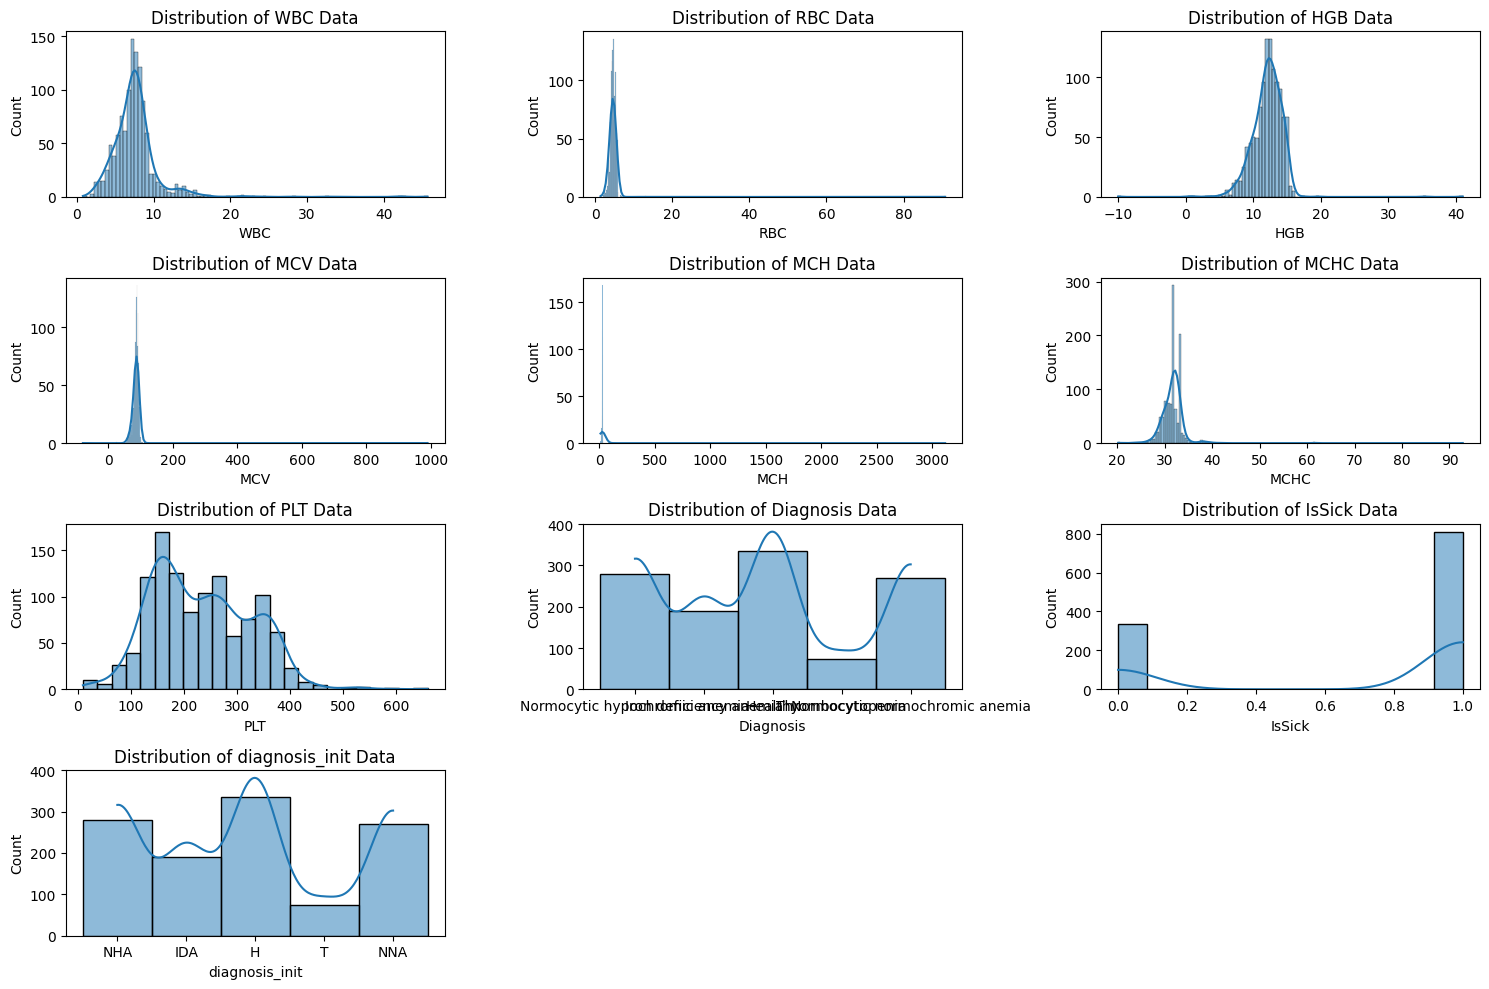

In [253]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1146 entries, 0 to 1280
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WBC             1146 non-null   float64
 1   RBC             1146 non-null   float64
 2   HGB             1146 non-null   float64
 3   MCV             1146 non-null   float64
 4   MCH             1146 non-null   float64
 5   MCHC            1146 non-null   float64
 6   PLT             1146 non-null   float64
 7   Diagnosis       1146 non-null   string 
 8   IsSick          1146 non-null   int64  
 9   diagnosis_init  1146 non-null   object 
dtypes: float64(7), int64(1), object(1), string(1)
memory usage: 98.5+ KB


In [255]:
df.isnull().sum()

WBC               0
RBC               0
HGB               0
MCV               0
MCH               0
MCHC              0
PLT               0
Diagnosis         0
IsSick            0
diagnosis_init    0
dtype: int64

In [256]:
df.drop_duplicates()

df.shape[0]

1146

In [257]:
def visualisation_quantitative(var):
    fig, axes = plt.subplots(3, 2, figsize=(30, 20))

    # Boxplot
    sns.boxplot(data=df, x=var, ax=axes[0][0])
    sns.boxplot(data=df, x="Diagnosis", y=var, ax=axes[0][1])
    axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, ha='right')

    # Histogram
    sns.histplot(data=df, x=var, ax=axes[1][0])
    sns.histplot(data=df, x=var, kde=True, hue="Diagnosis", ax=axes[1][1])
    
    # Scatter plot
    sns.scatterplot(data=df, x=var, y="Diagnosis", hue="Diagnosis", ax=axes[2][0], legend=False)

    # Count plot
    sns.countplot(data=df, x="Diagnosis", hue="Diagnosis", ax=axes[2][1])
    axes[2][1].set_xticklabels(axes[2][1].get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

WBC


C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, ha='right')
C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][1].set_xticklabels(axes[2][1].get_xticklabels(), rotation=45, ha='right')


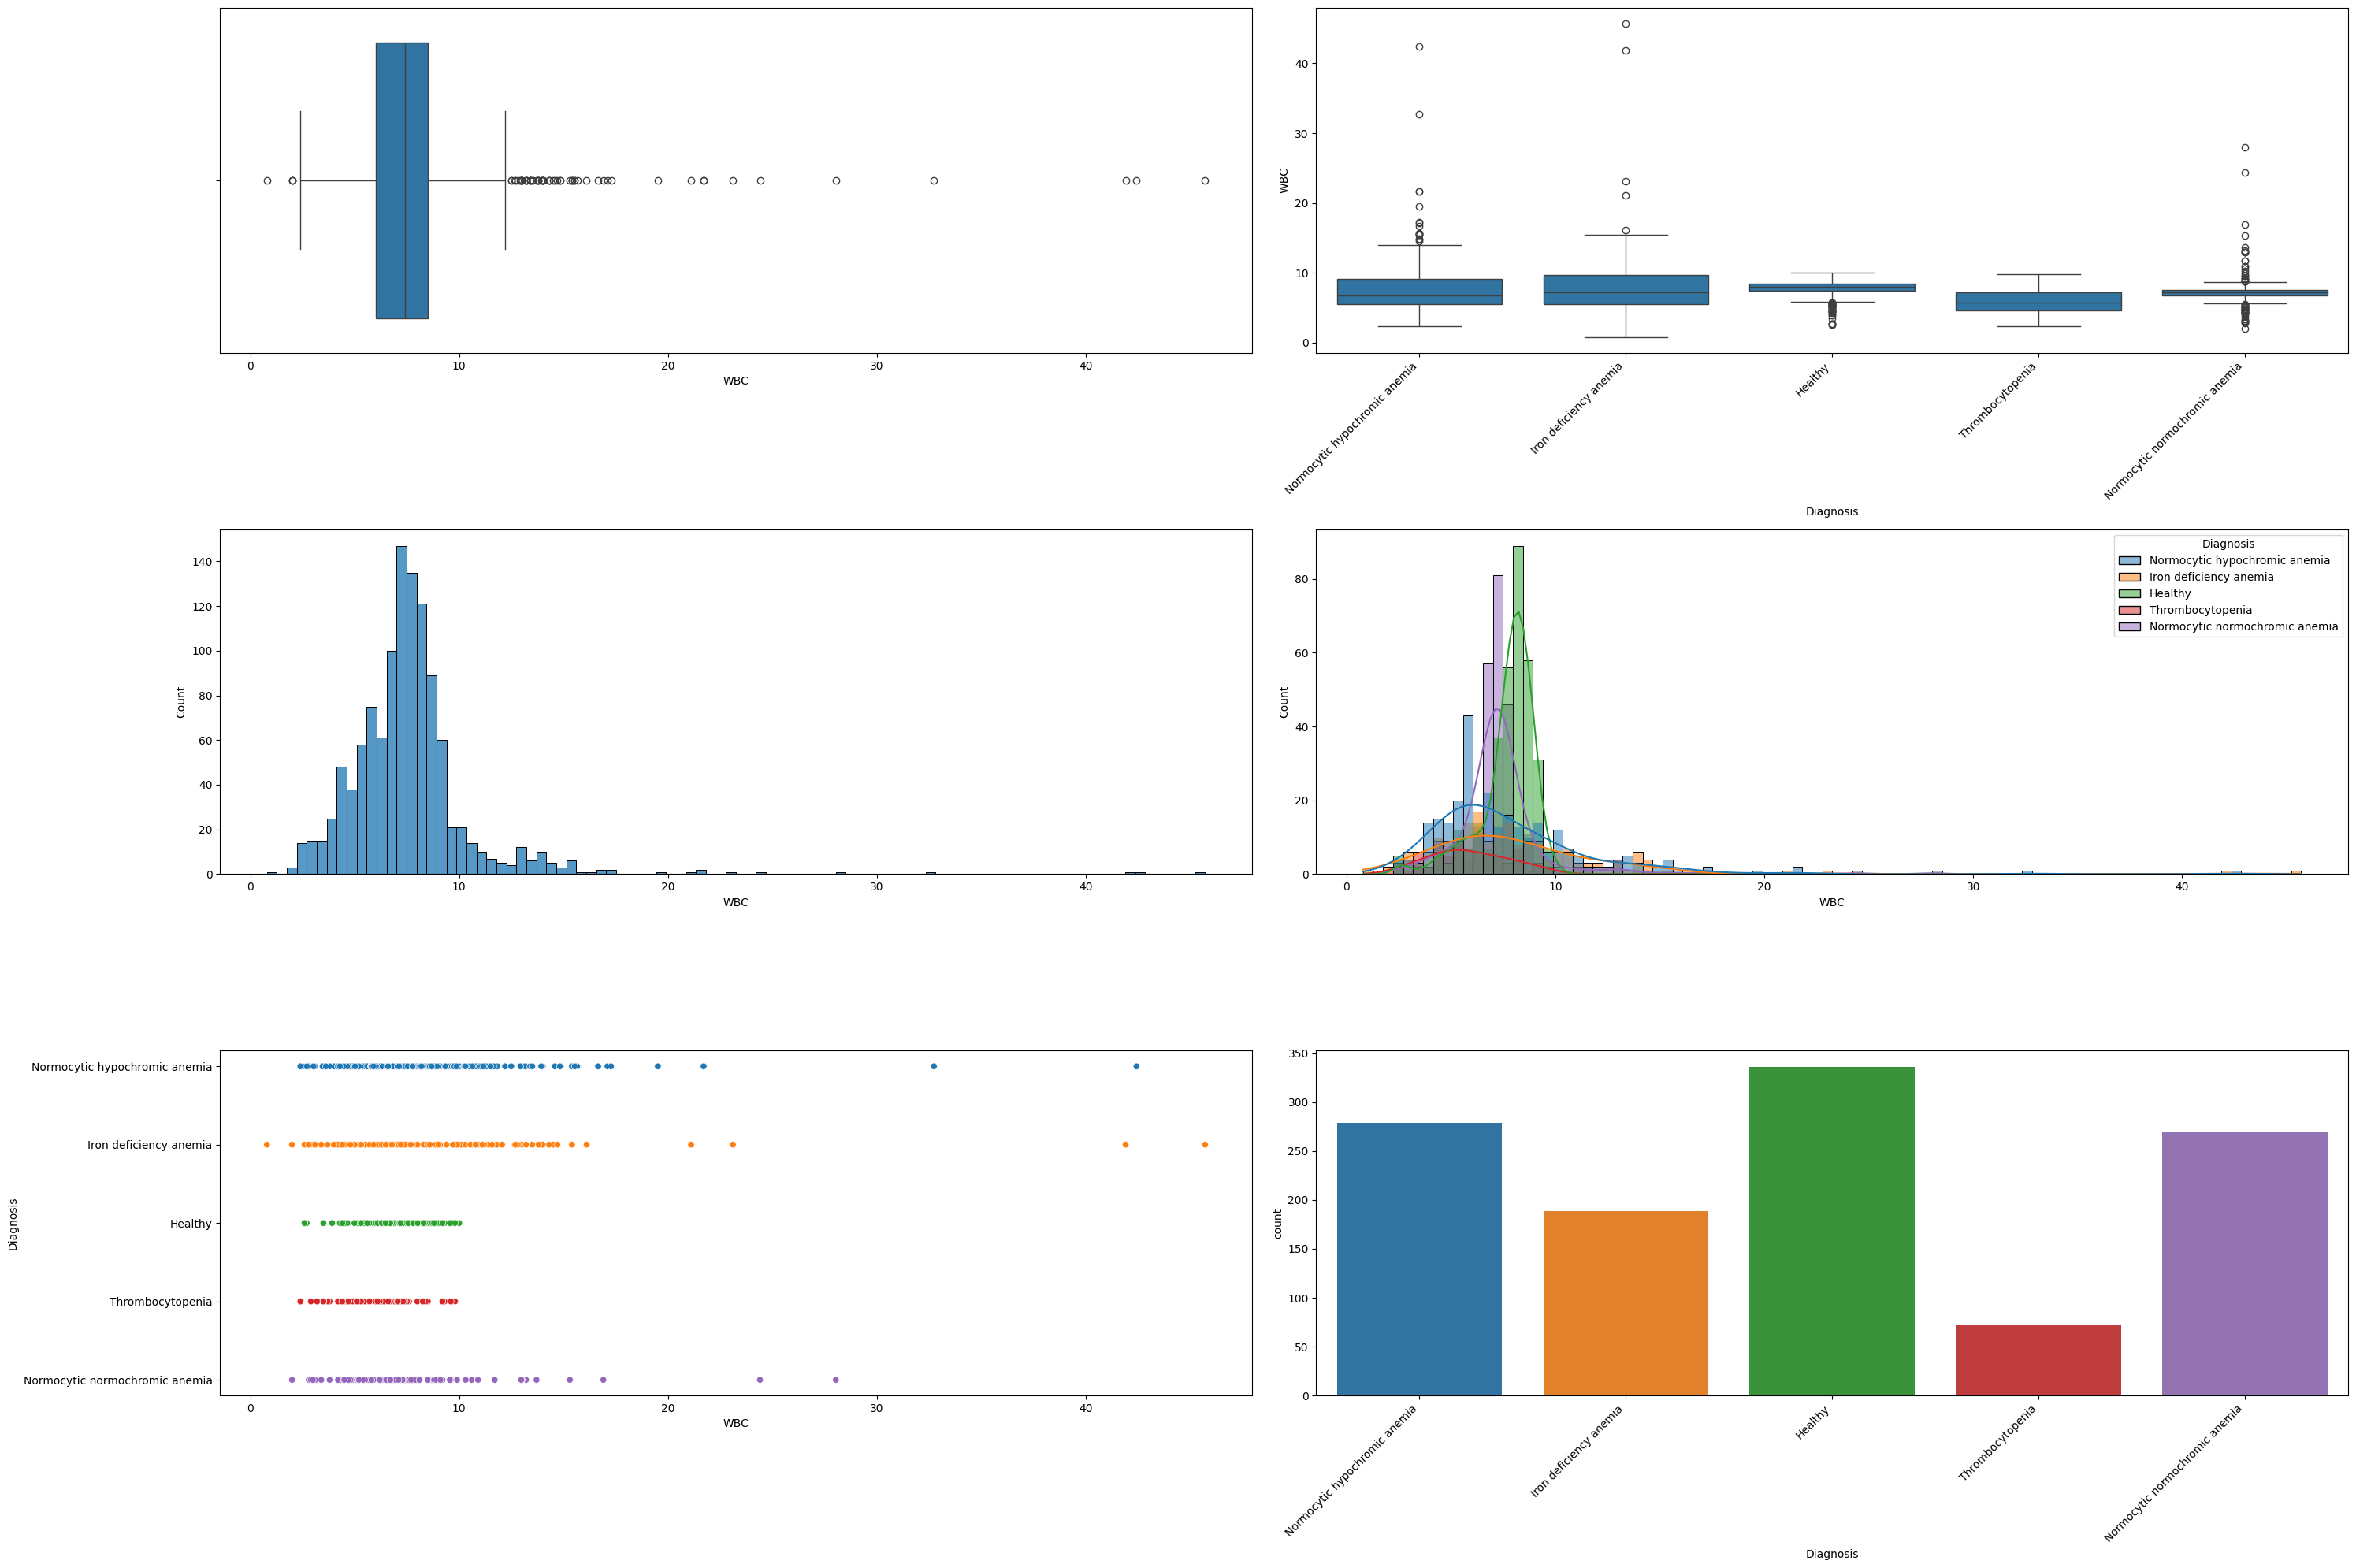

RBC


C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, ha='right')
C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][1].set_xticklabels(axes[2][1].get_xticklabels(), rotation=45, ha='right')


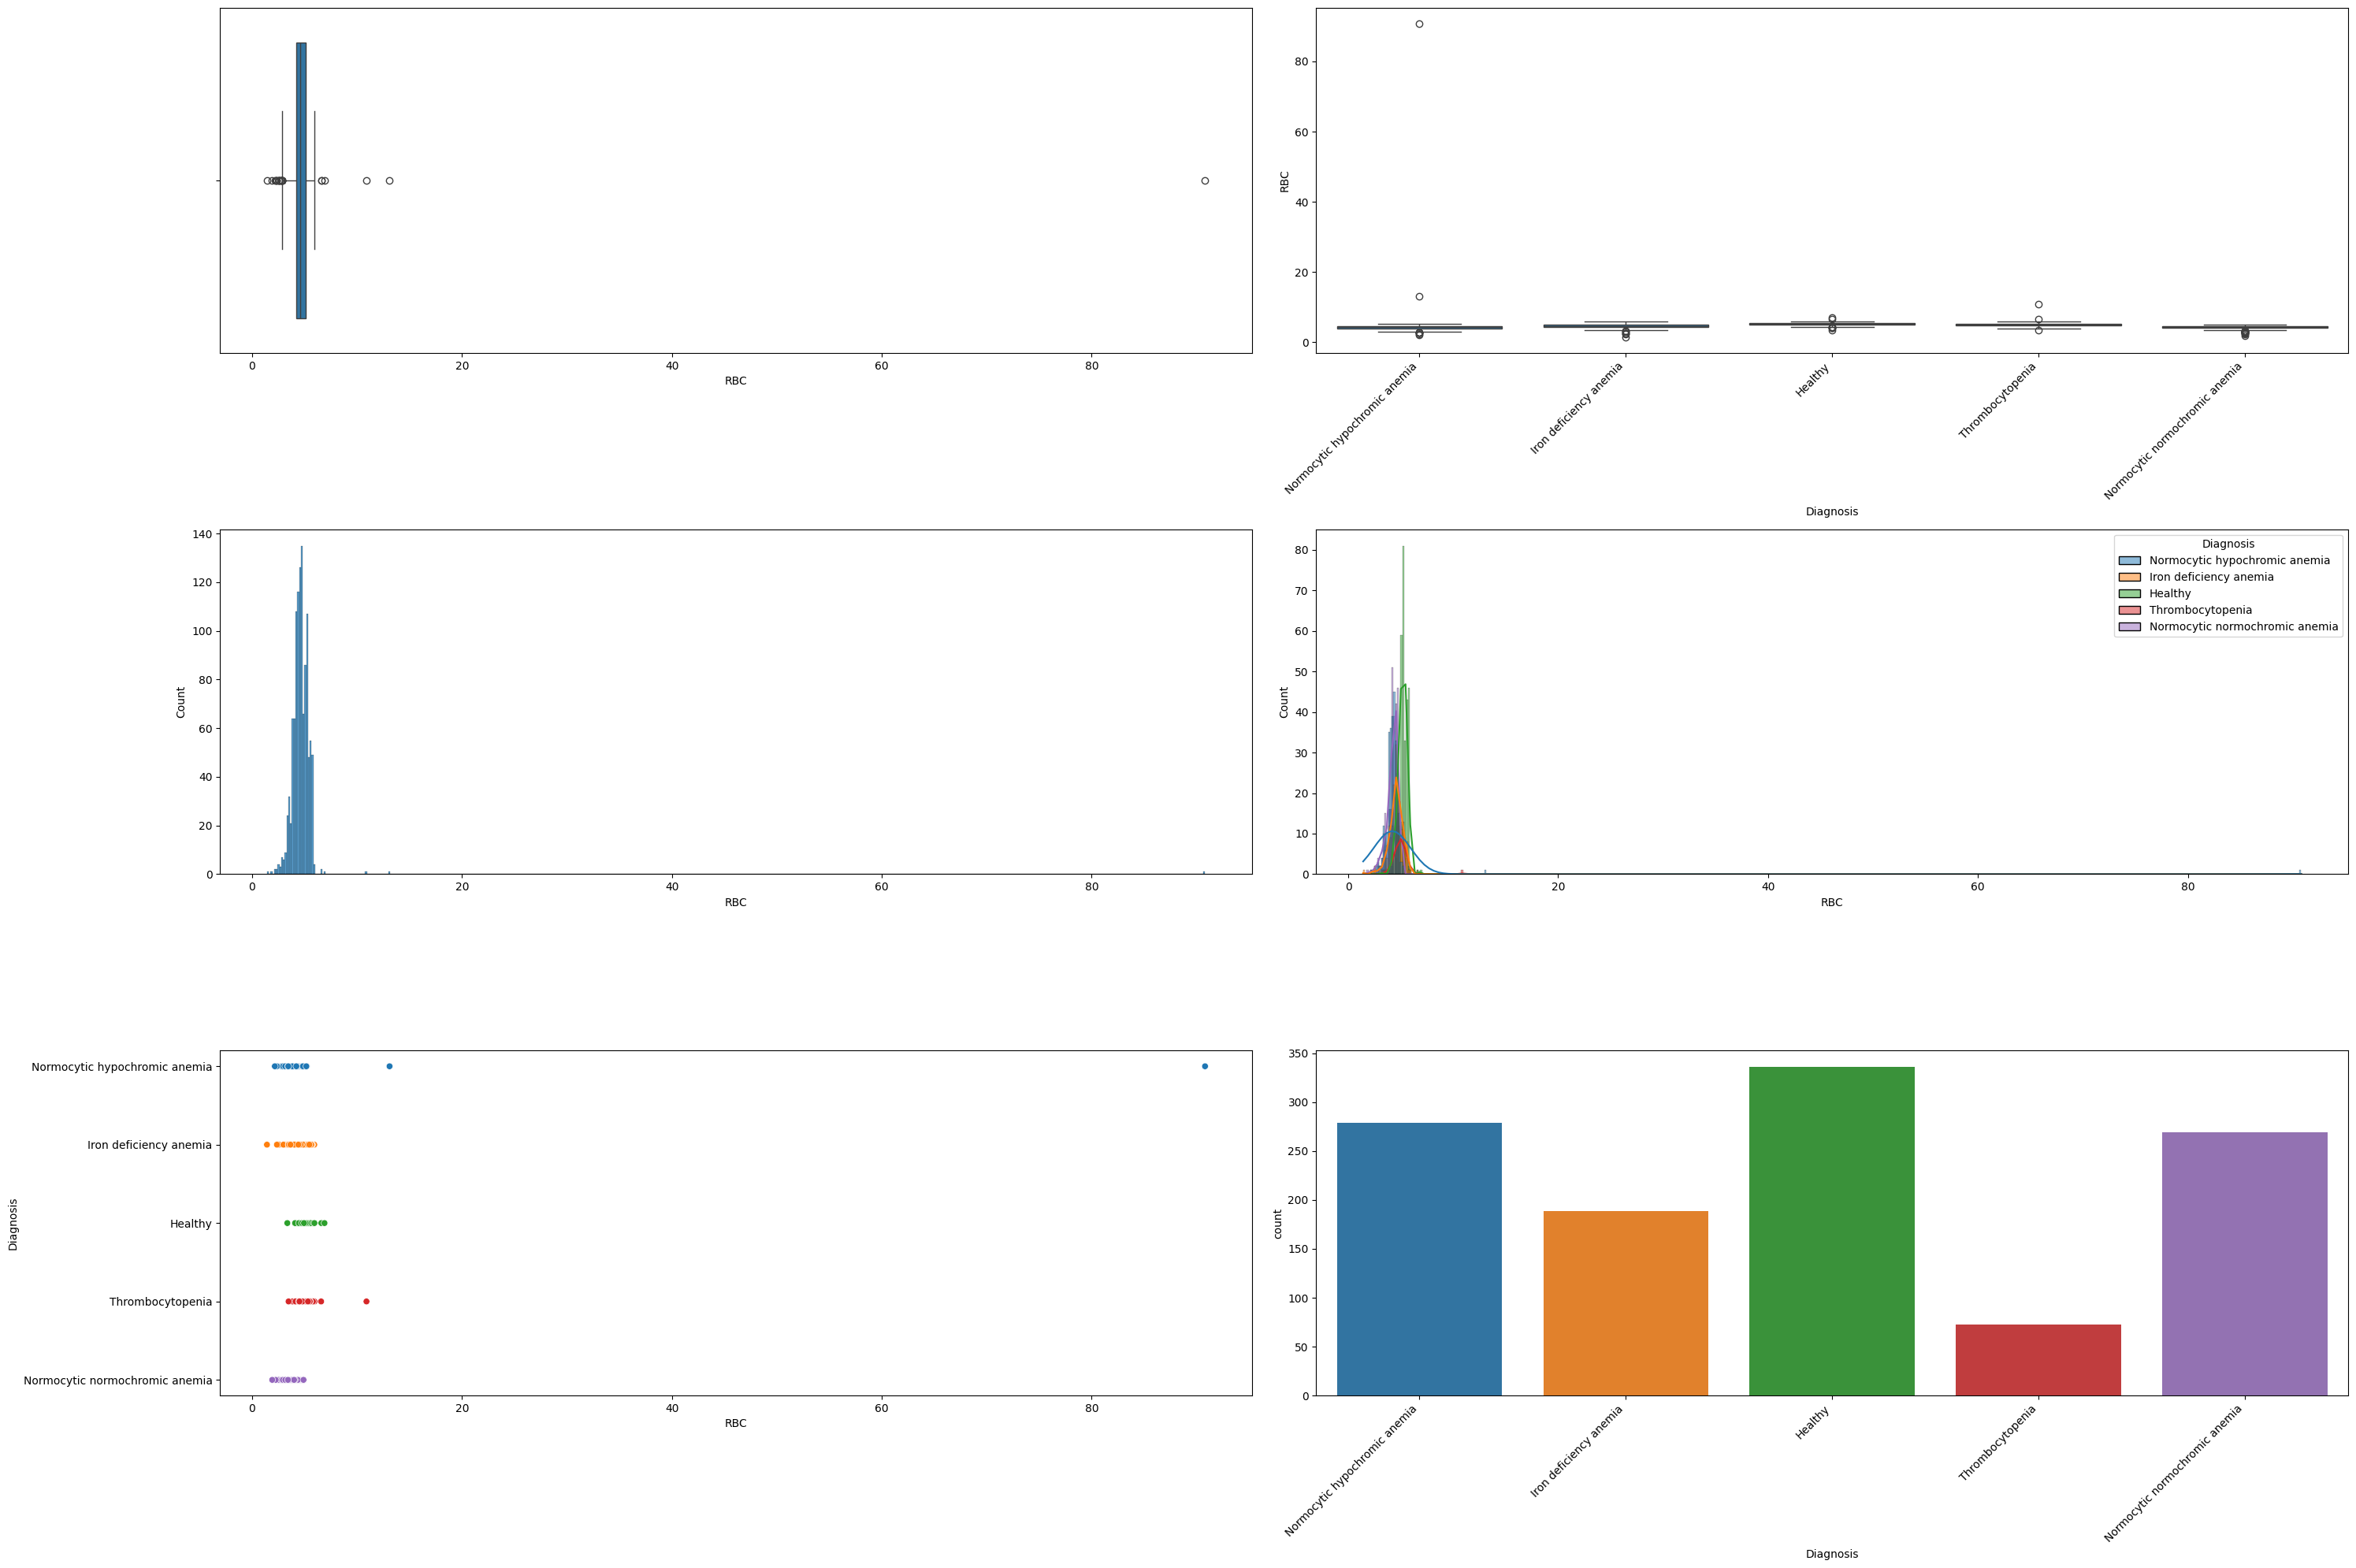

HGB


C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, ha='right')
C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][1].set_xticklabels(axes[2][1].get_xticklabels(), rotation=45, ha='right')


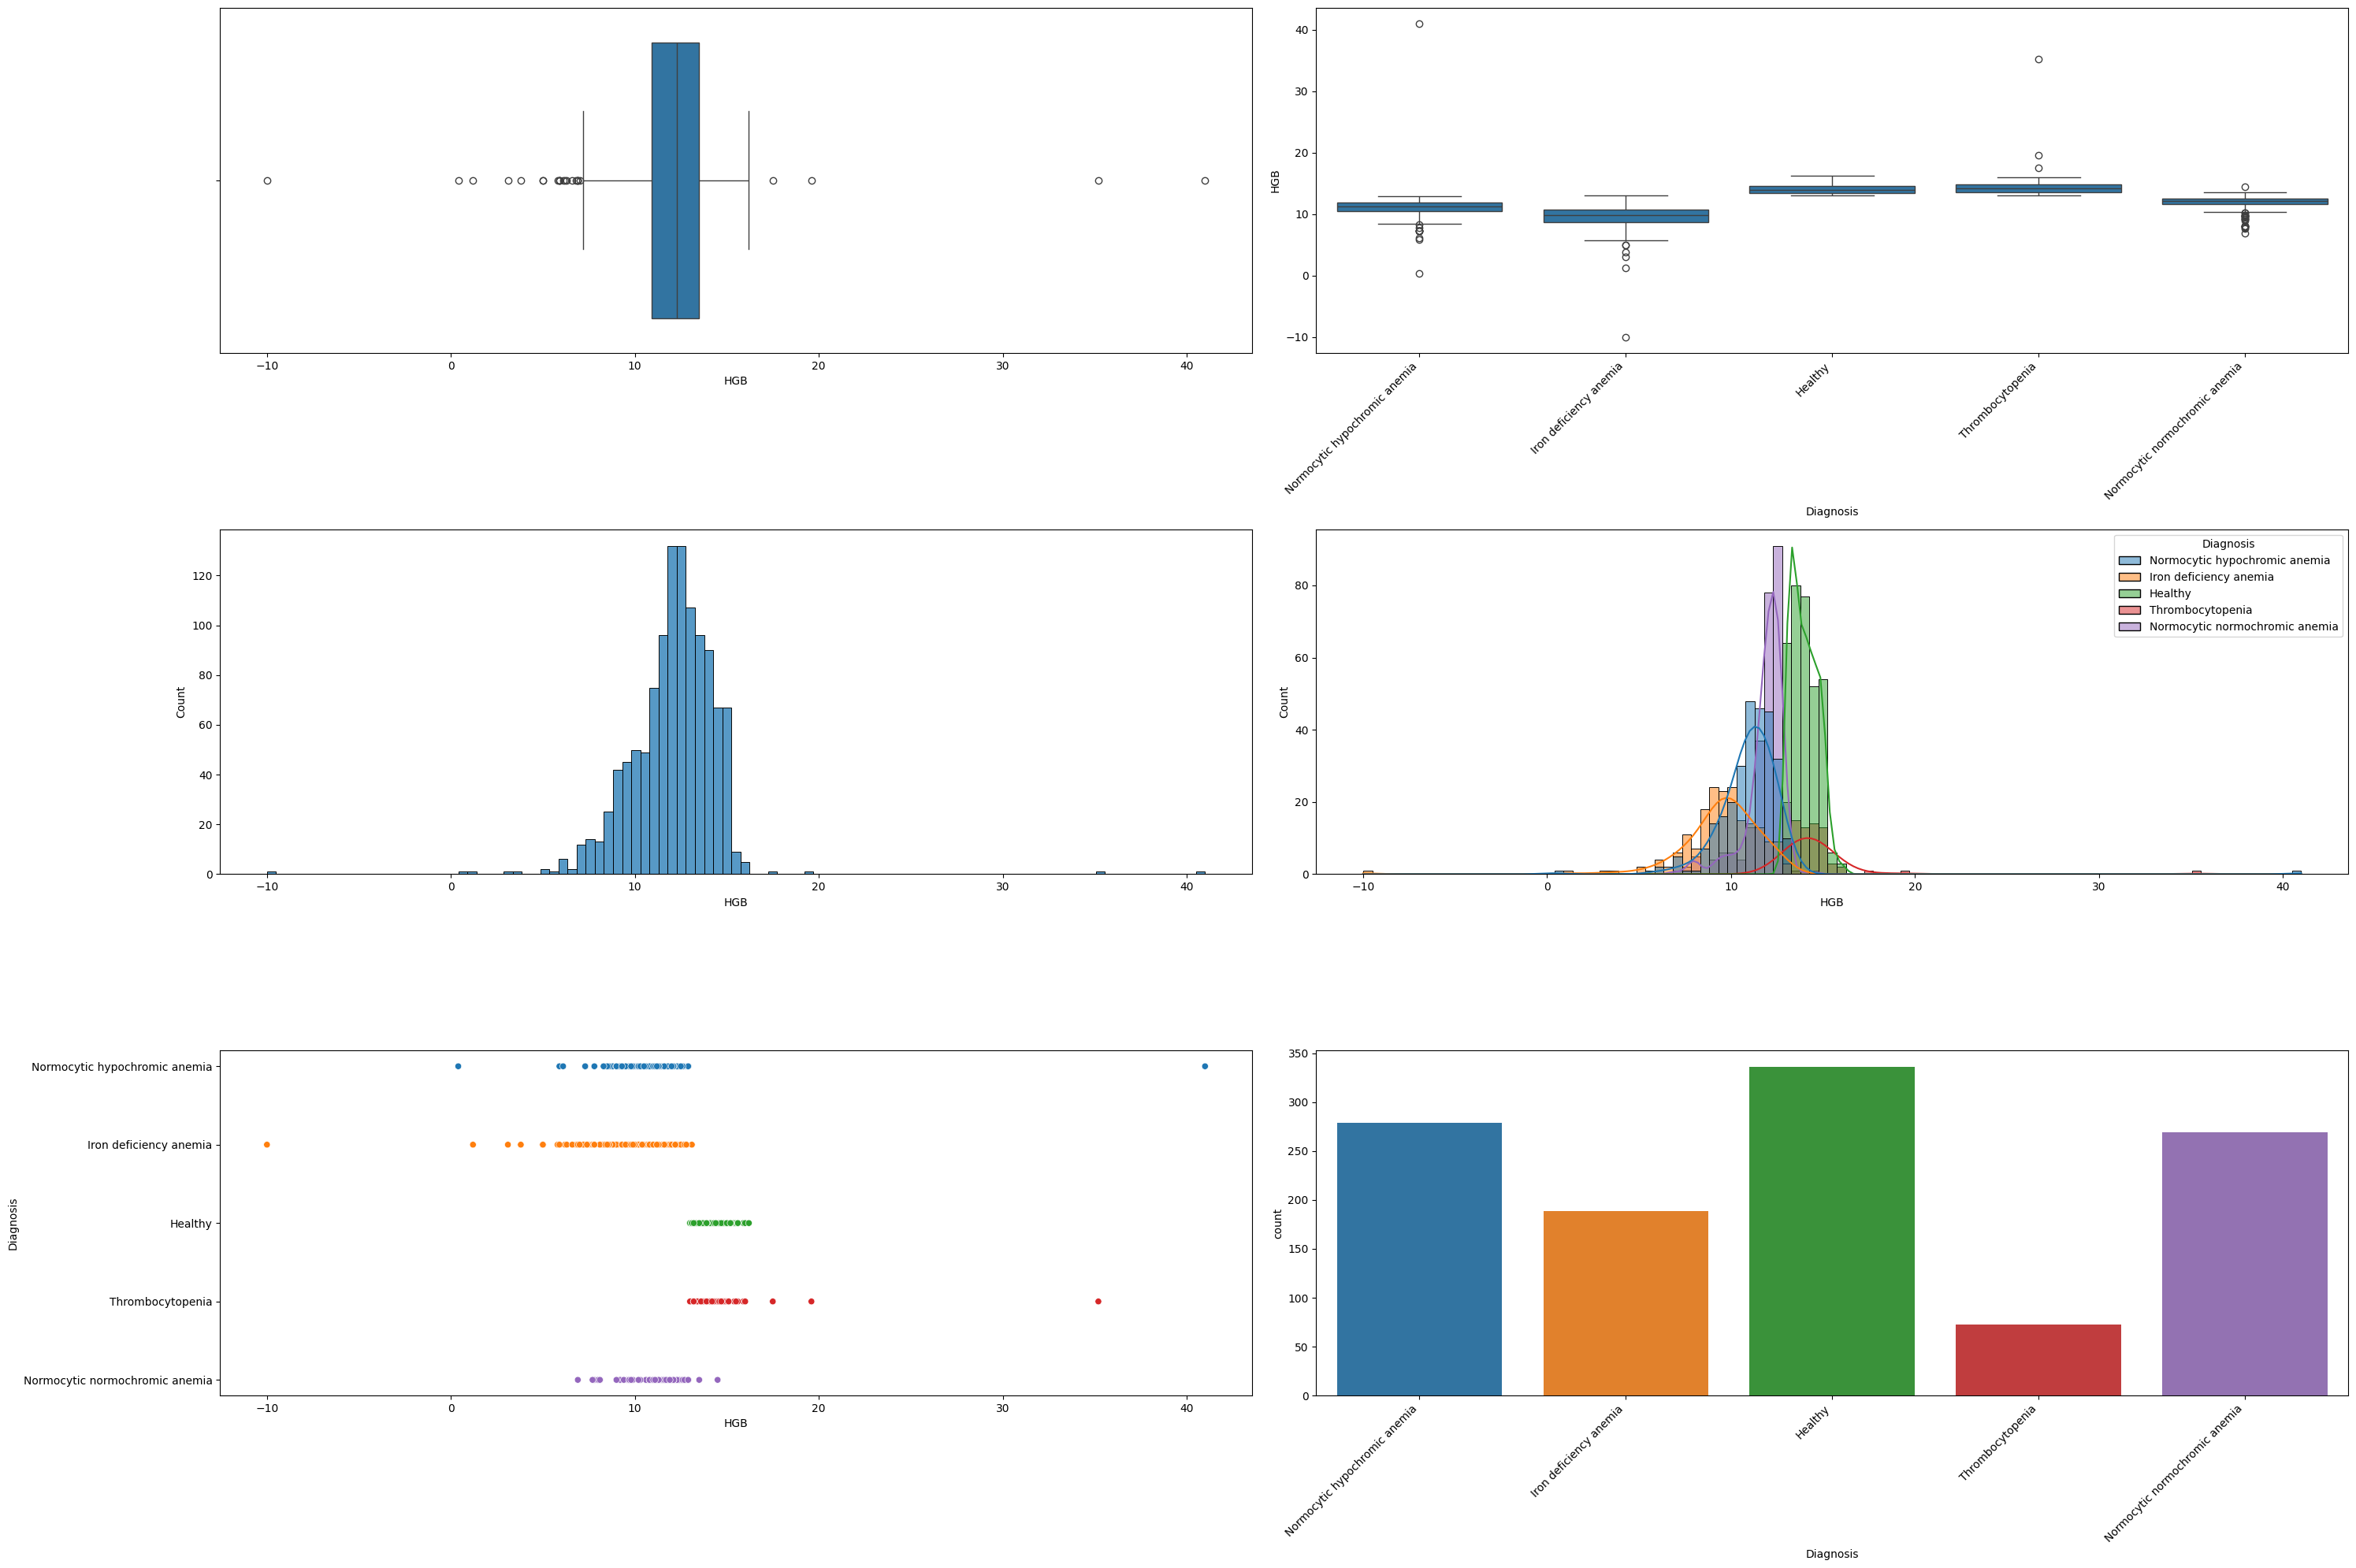

MCV


C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, ha='right')
C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][1].set_xticklabels(axes[2][1].get_xticklabels(), rotation=45, ha='right')


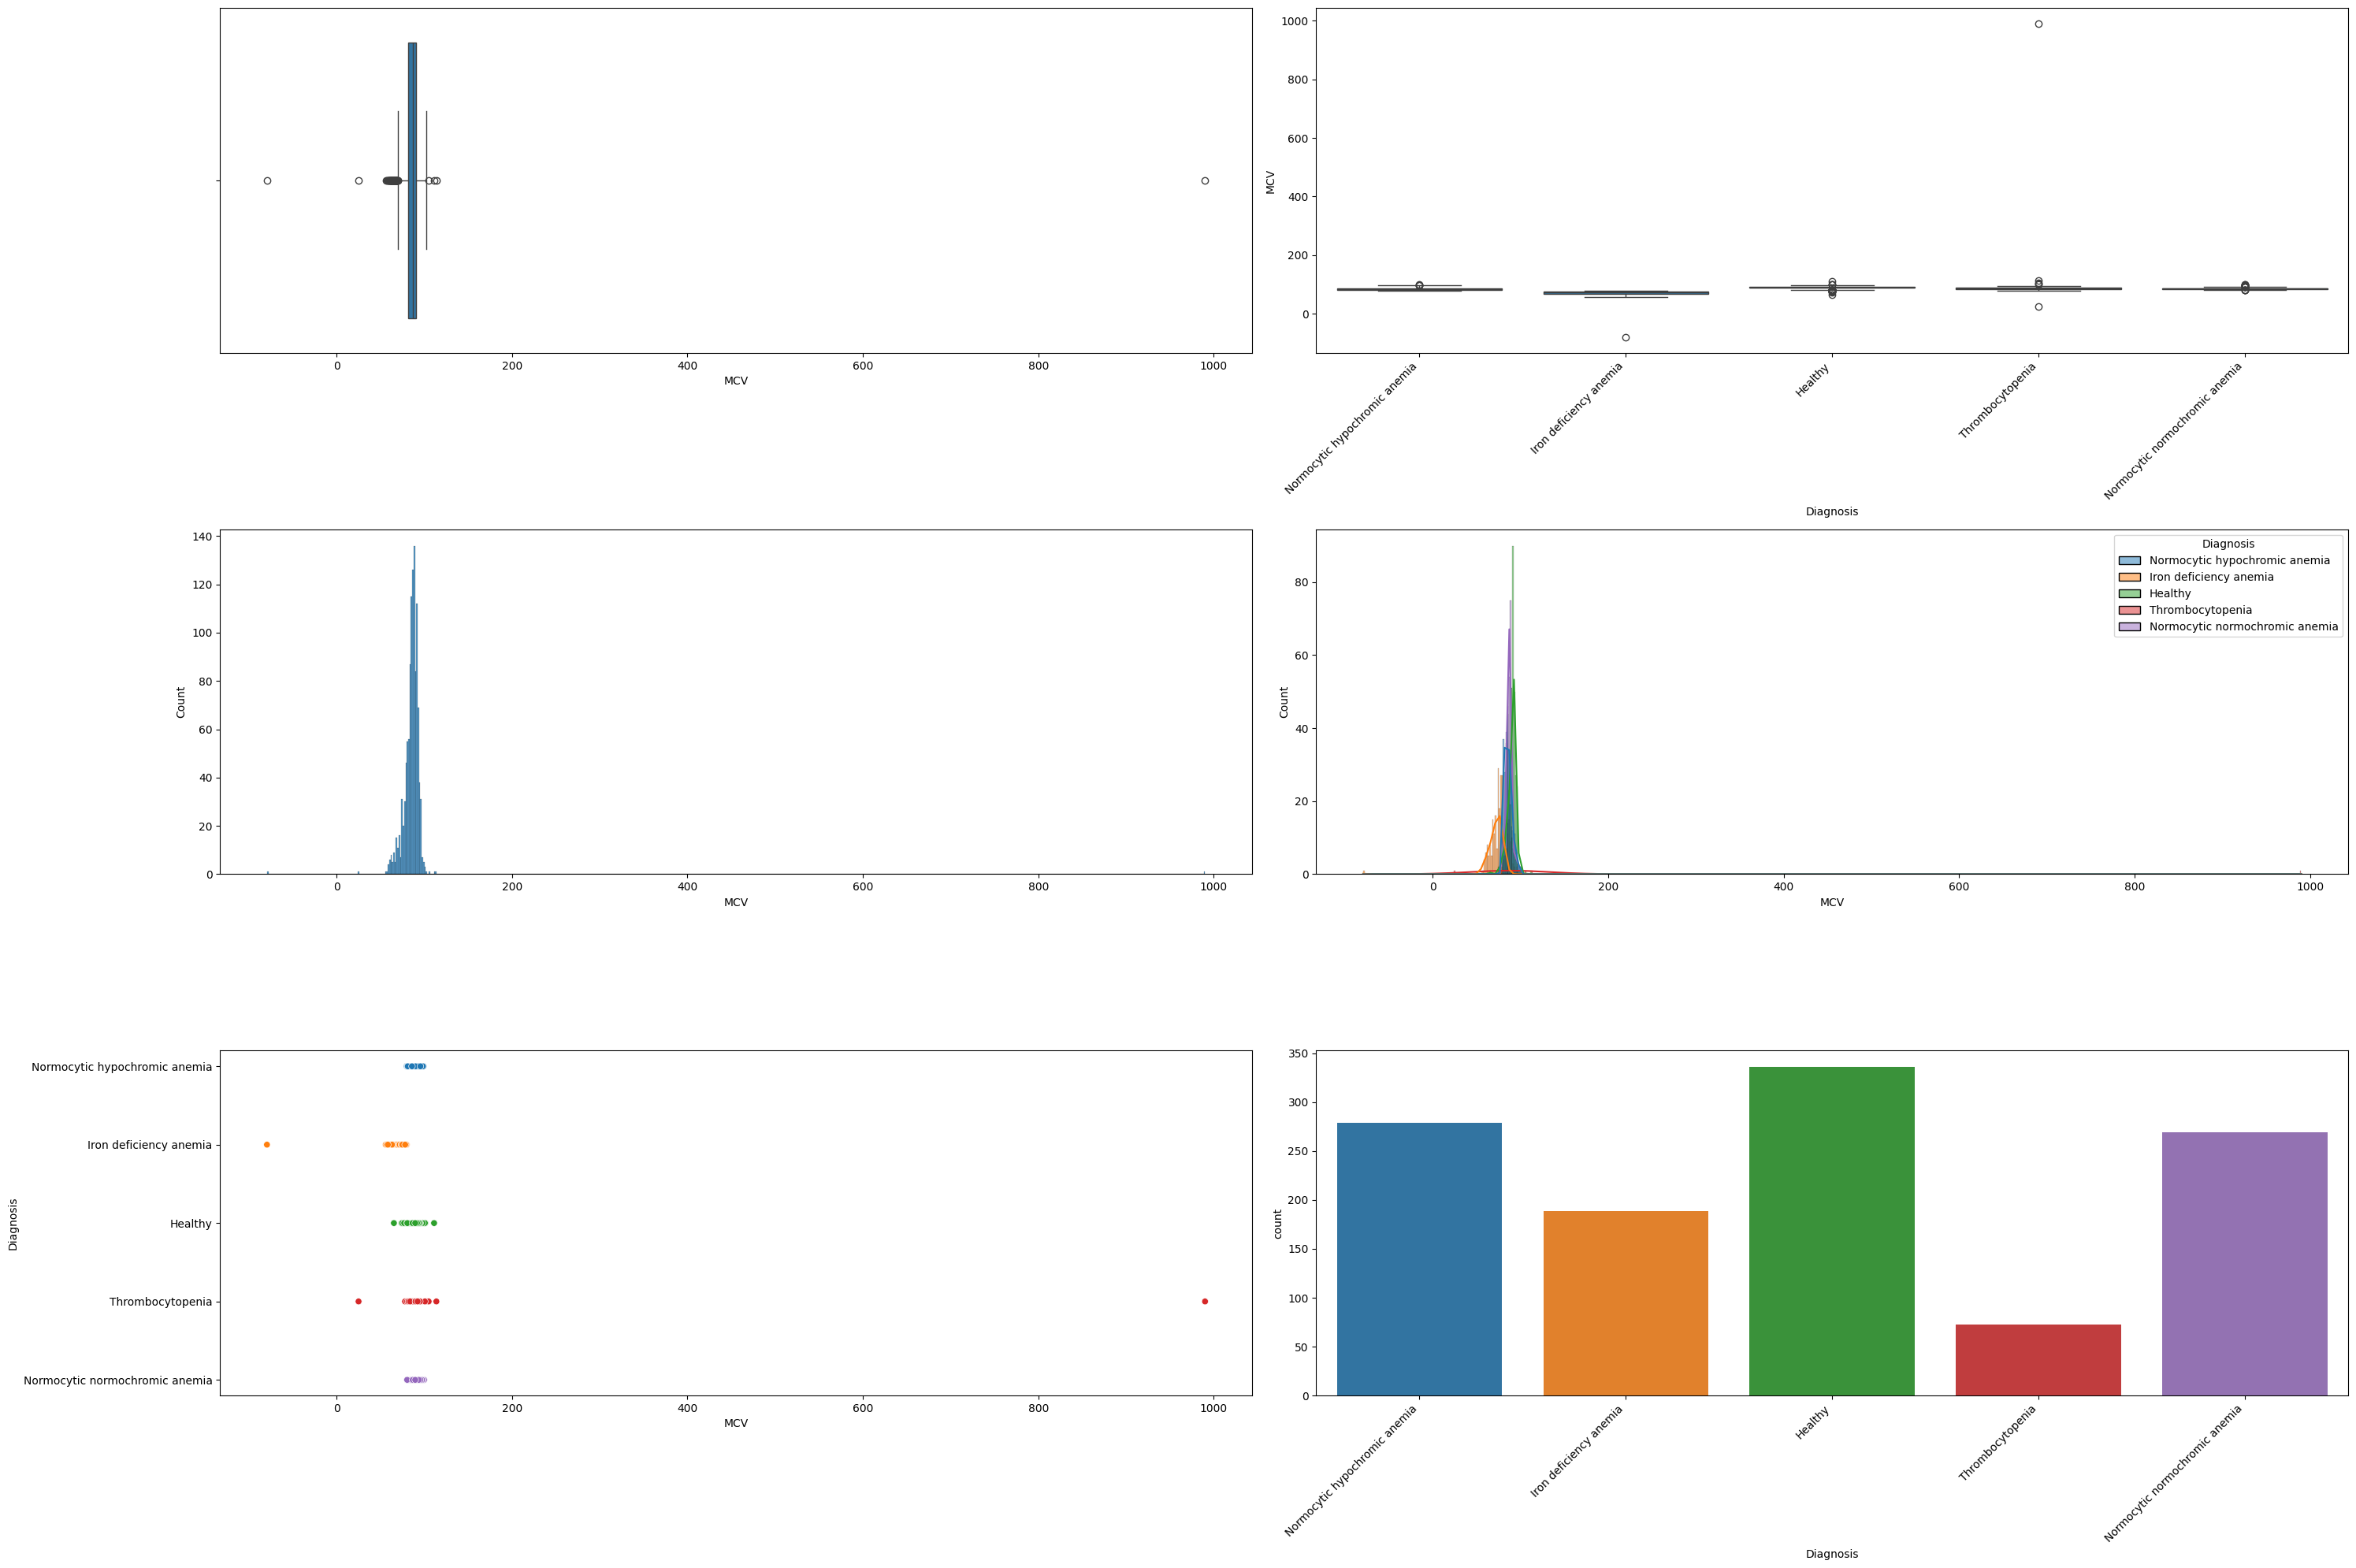

MCH


C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, ha='right')
C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][1].set_xticklabels(axes[2][1].get_xticklabels(), rotation=45, ha='right')


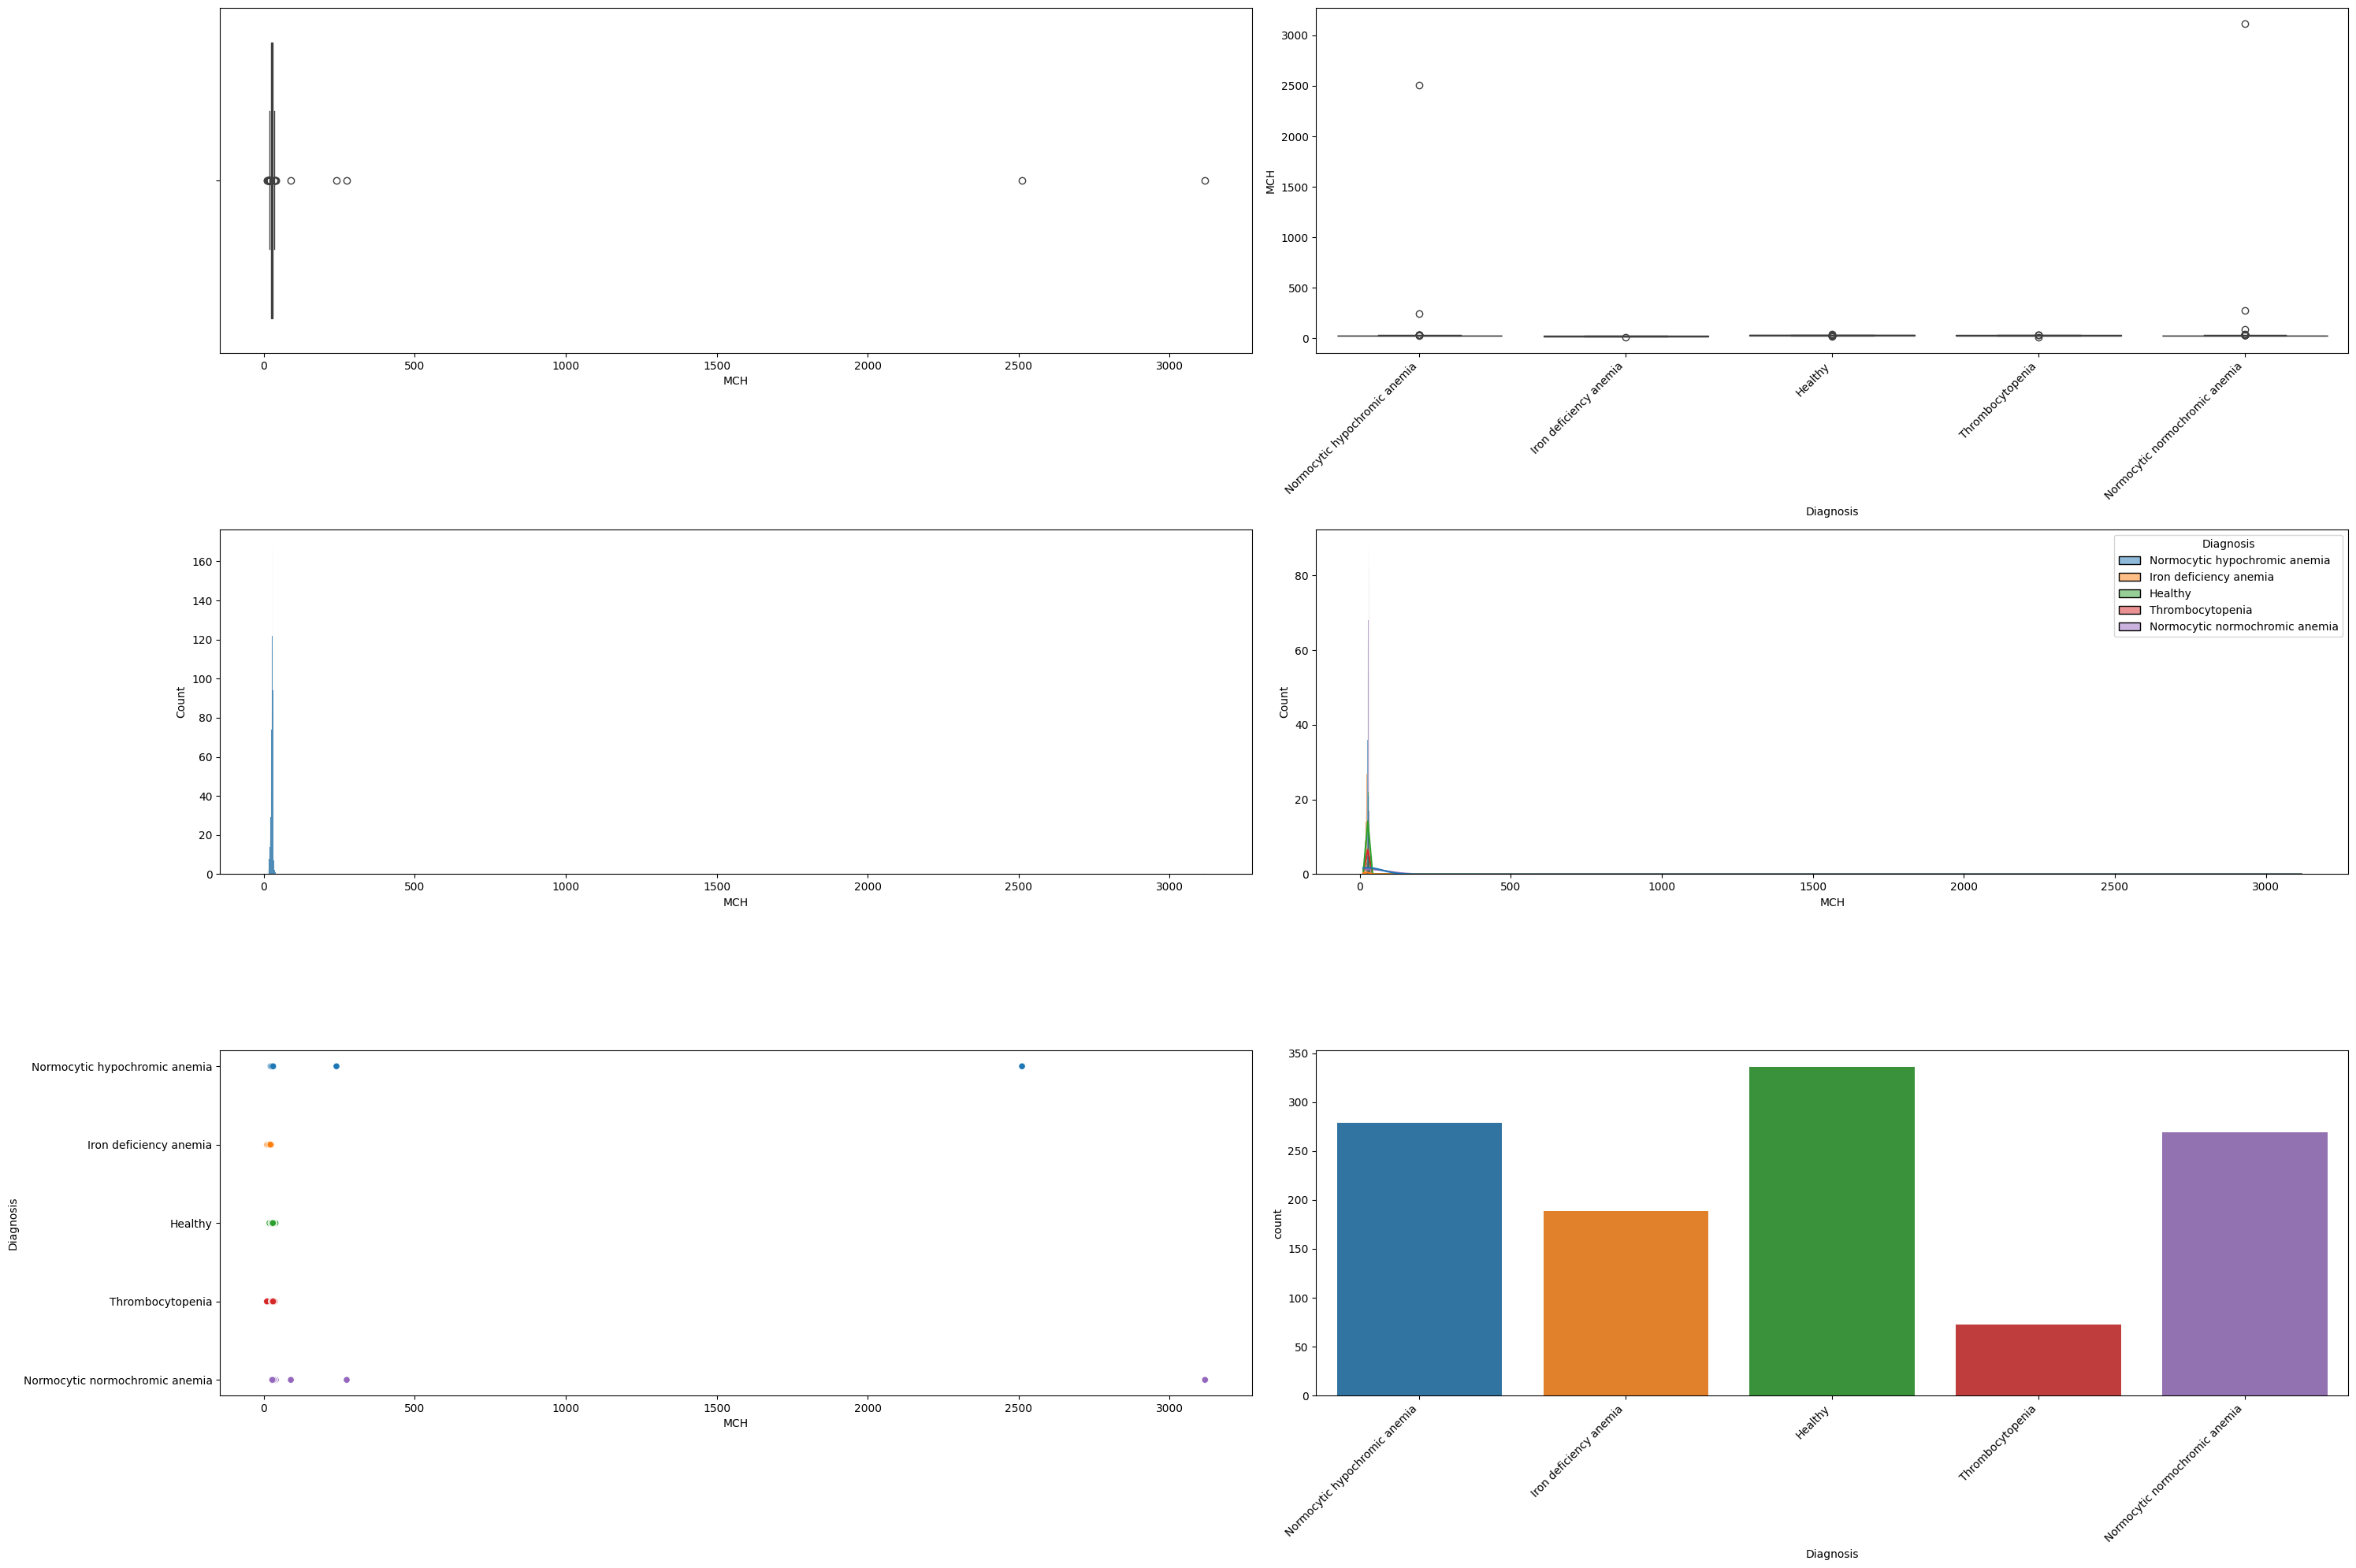

MCHC


C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, ha='right')
C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][1].set_xticklabels(axes[2][1].get_xticklabels(), rotation=45, ha='right')


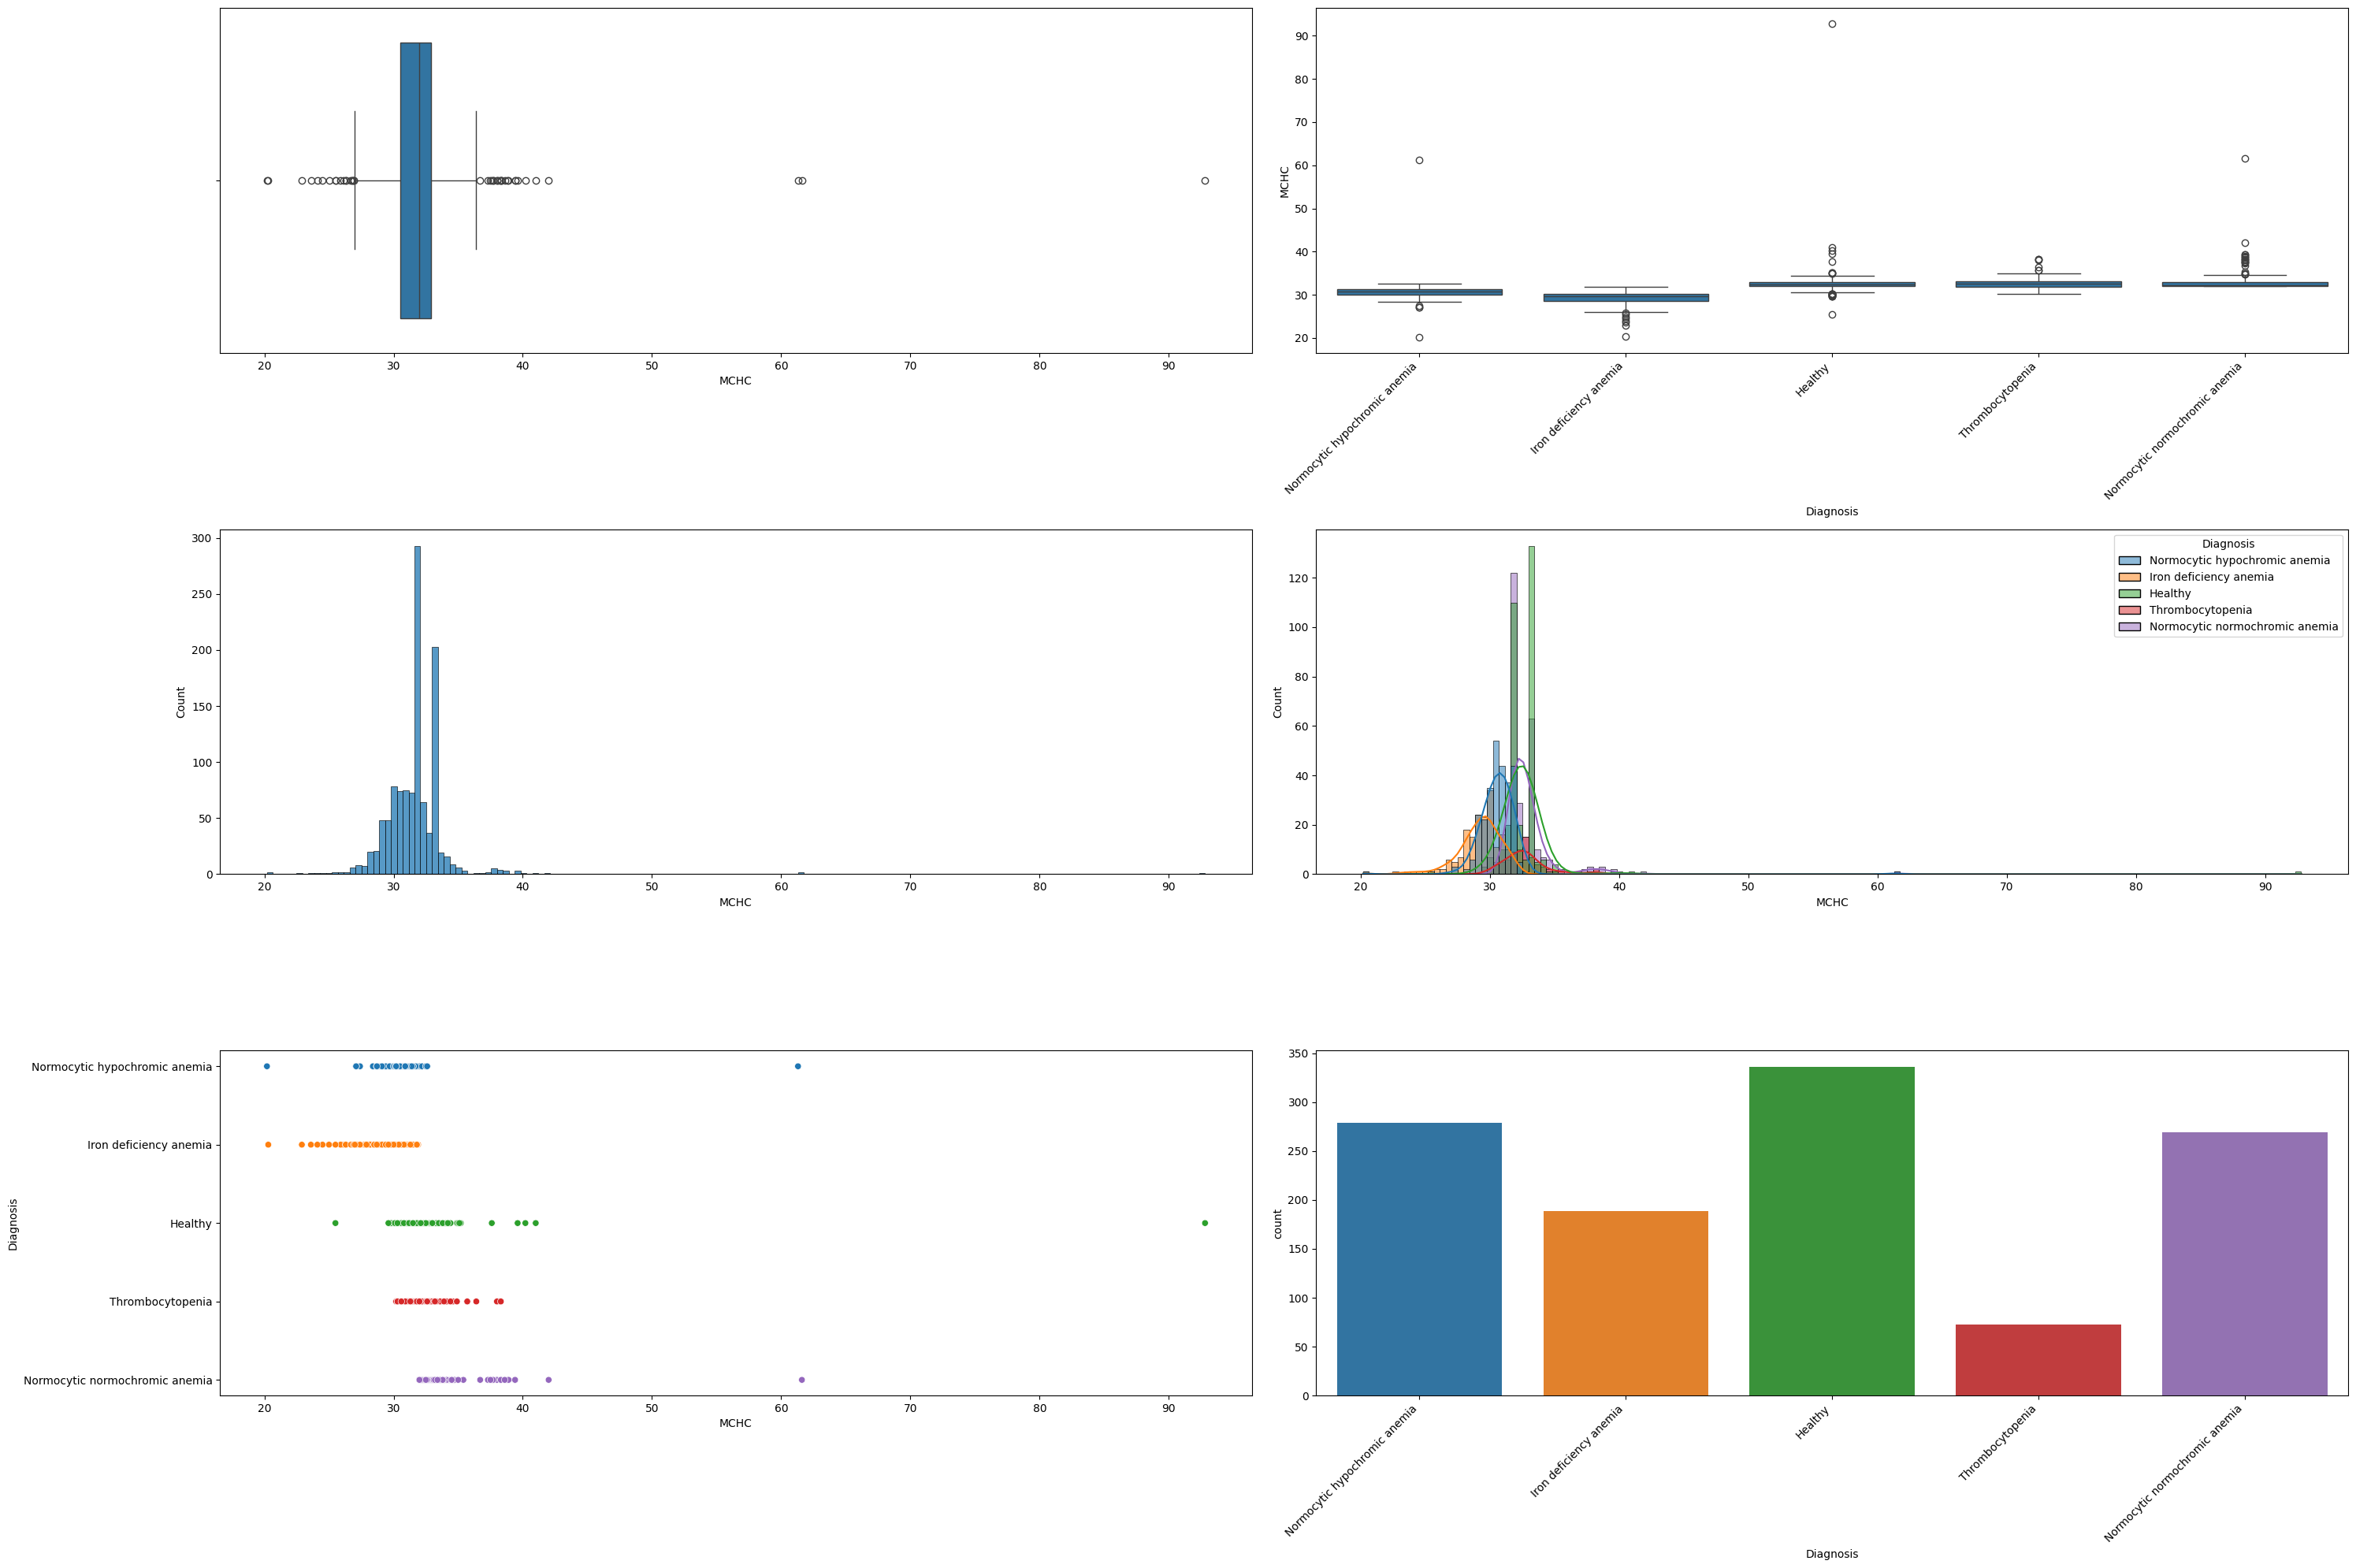

PLT


C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, ha='right')
C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][1].set_xticklabels(axes[2][1].get_xticklabels(), rotation=45, ha='right')


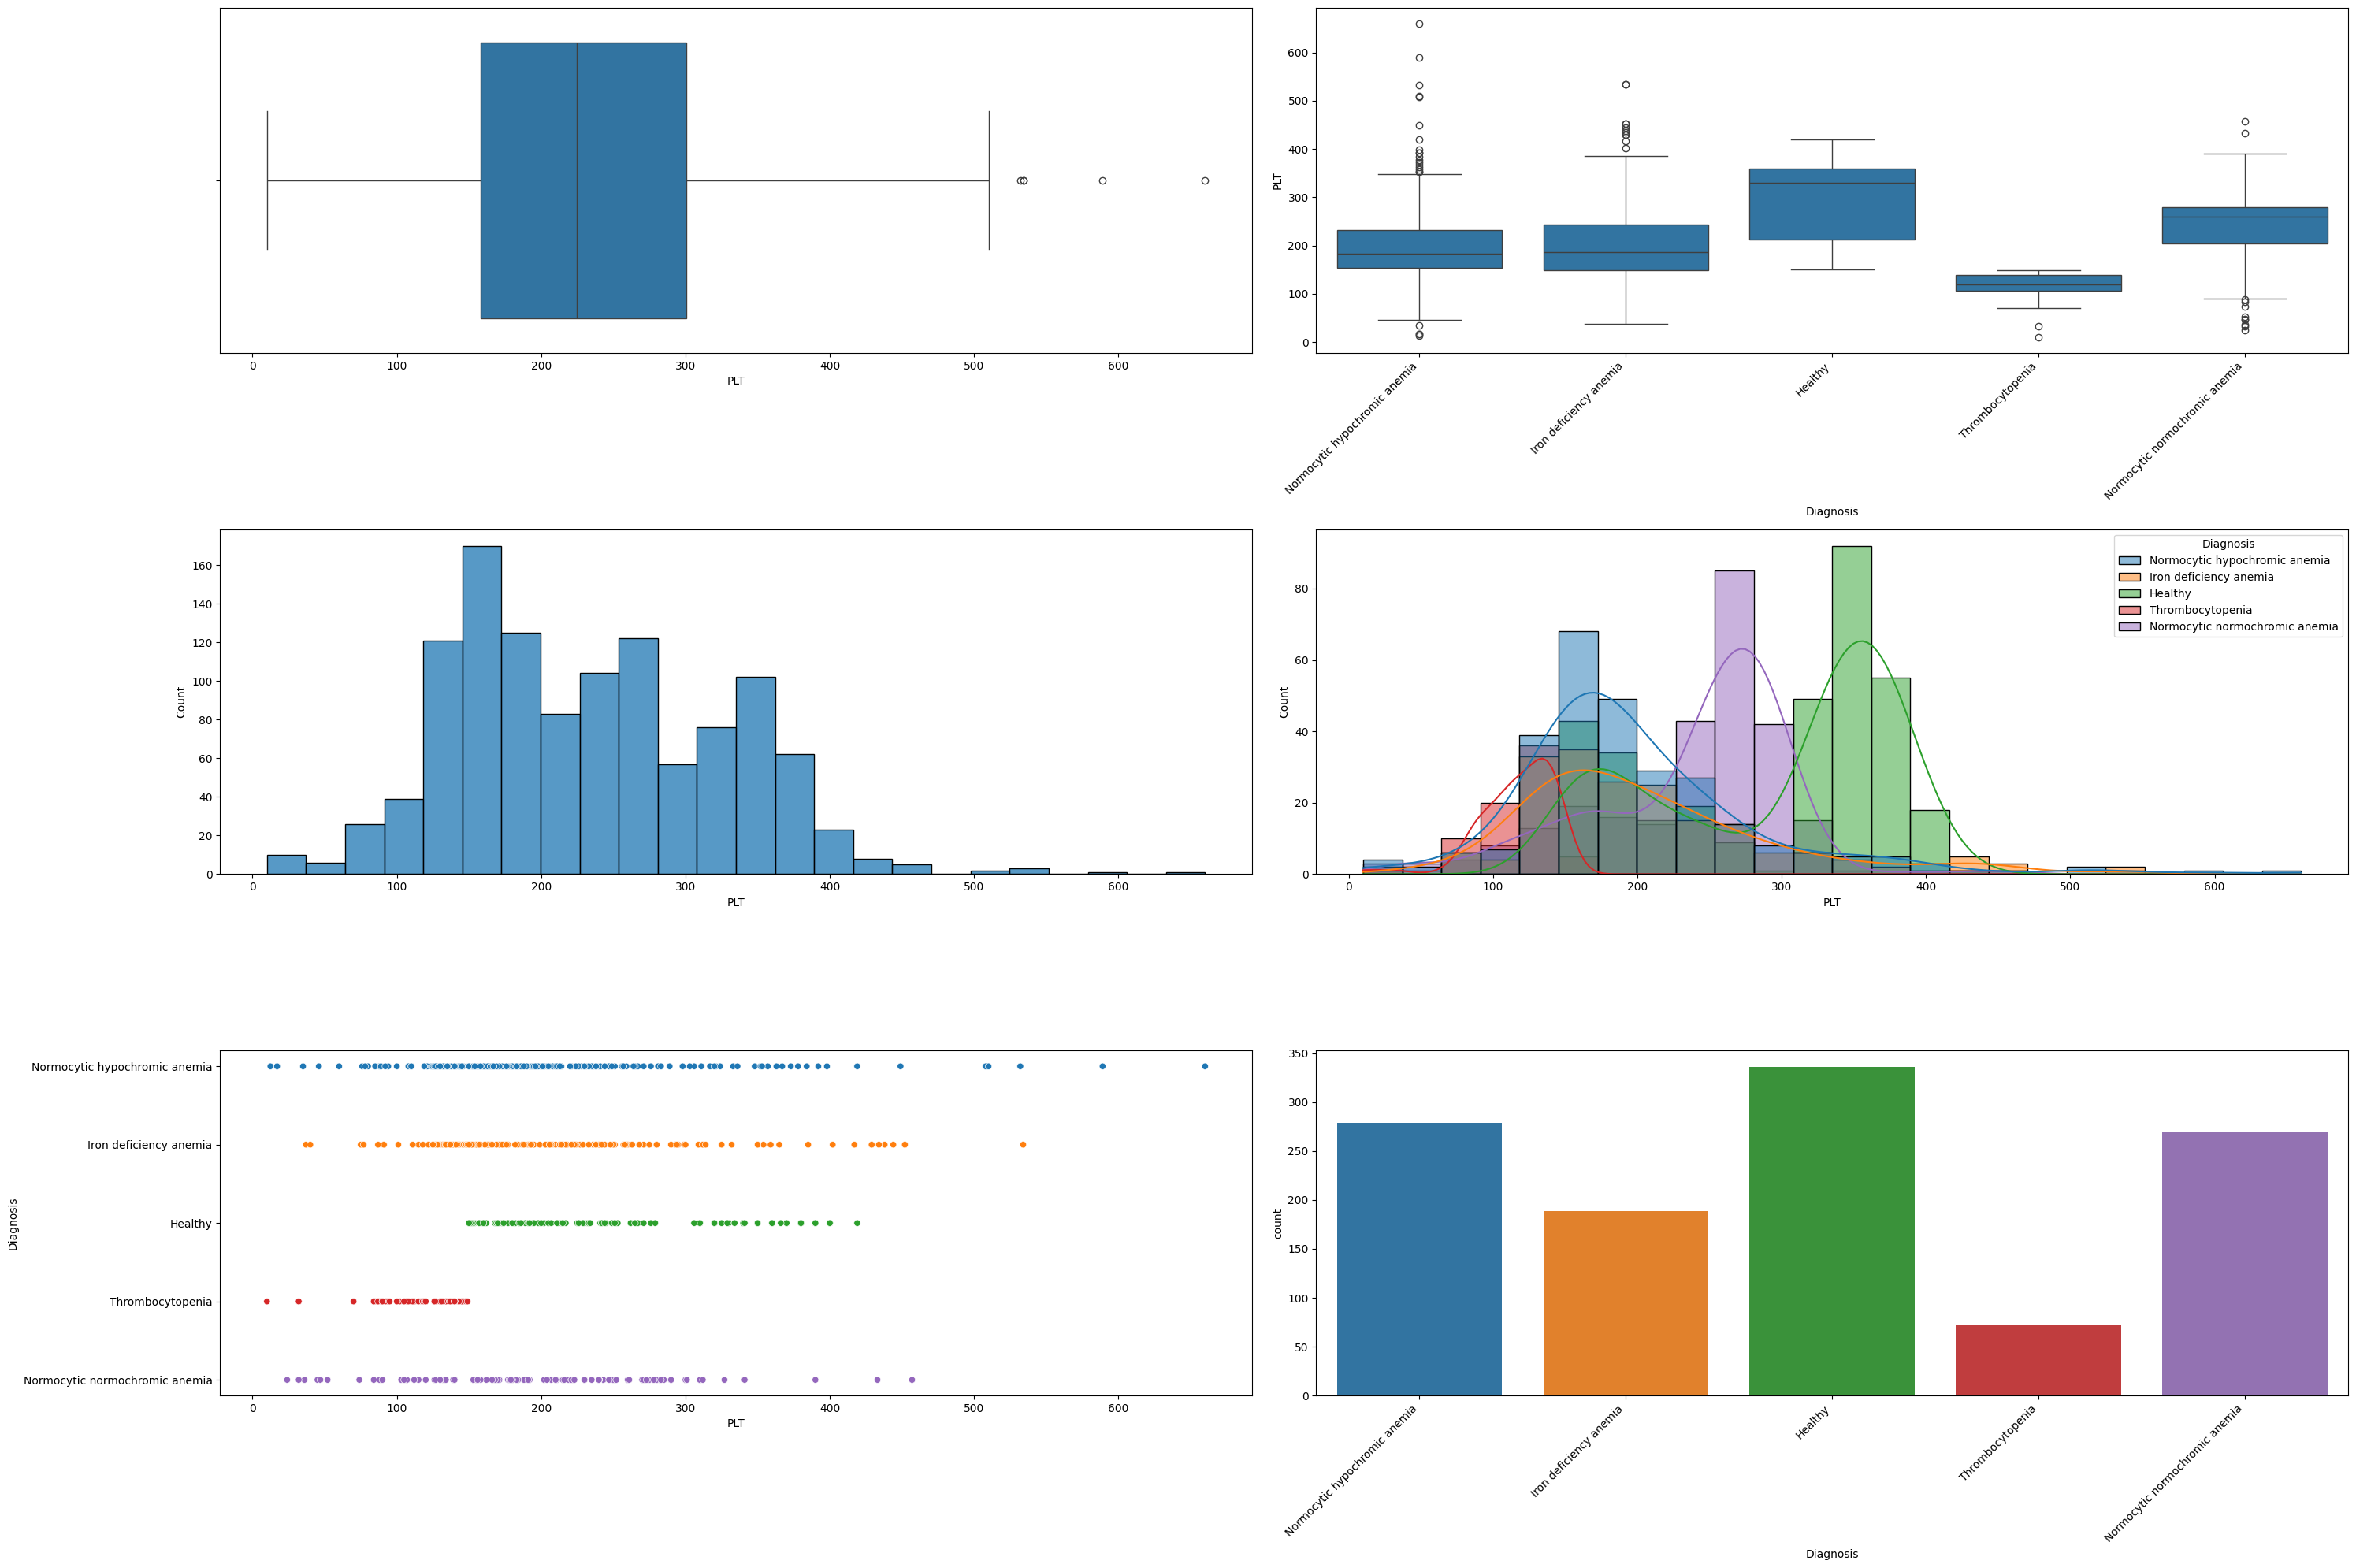

IsSick


C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, ha='right')
C:\Users\alexa\AppData\Local\Temp\ipykernel_25468\2181396881.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][1].set_xticklabels(axes[2][1].get_xticklabels(), rotation=45, ha='right')


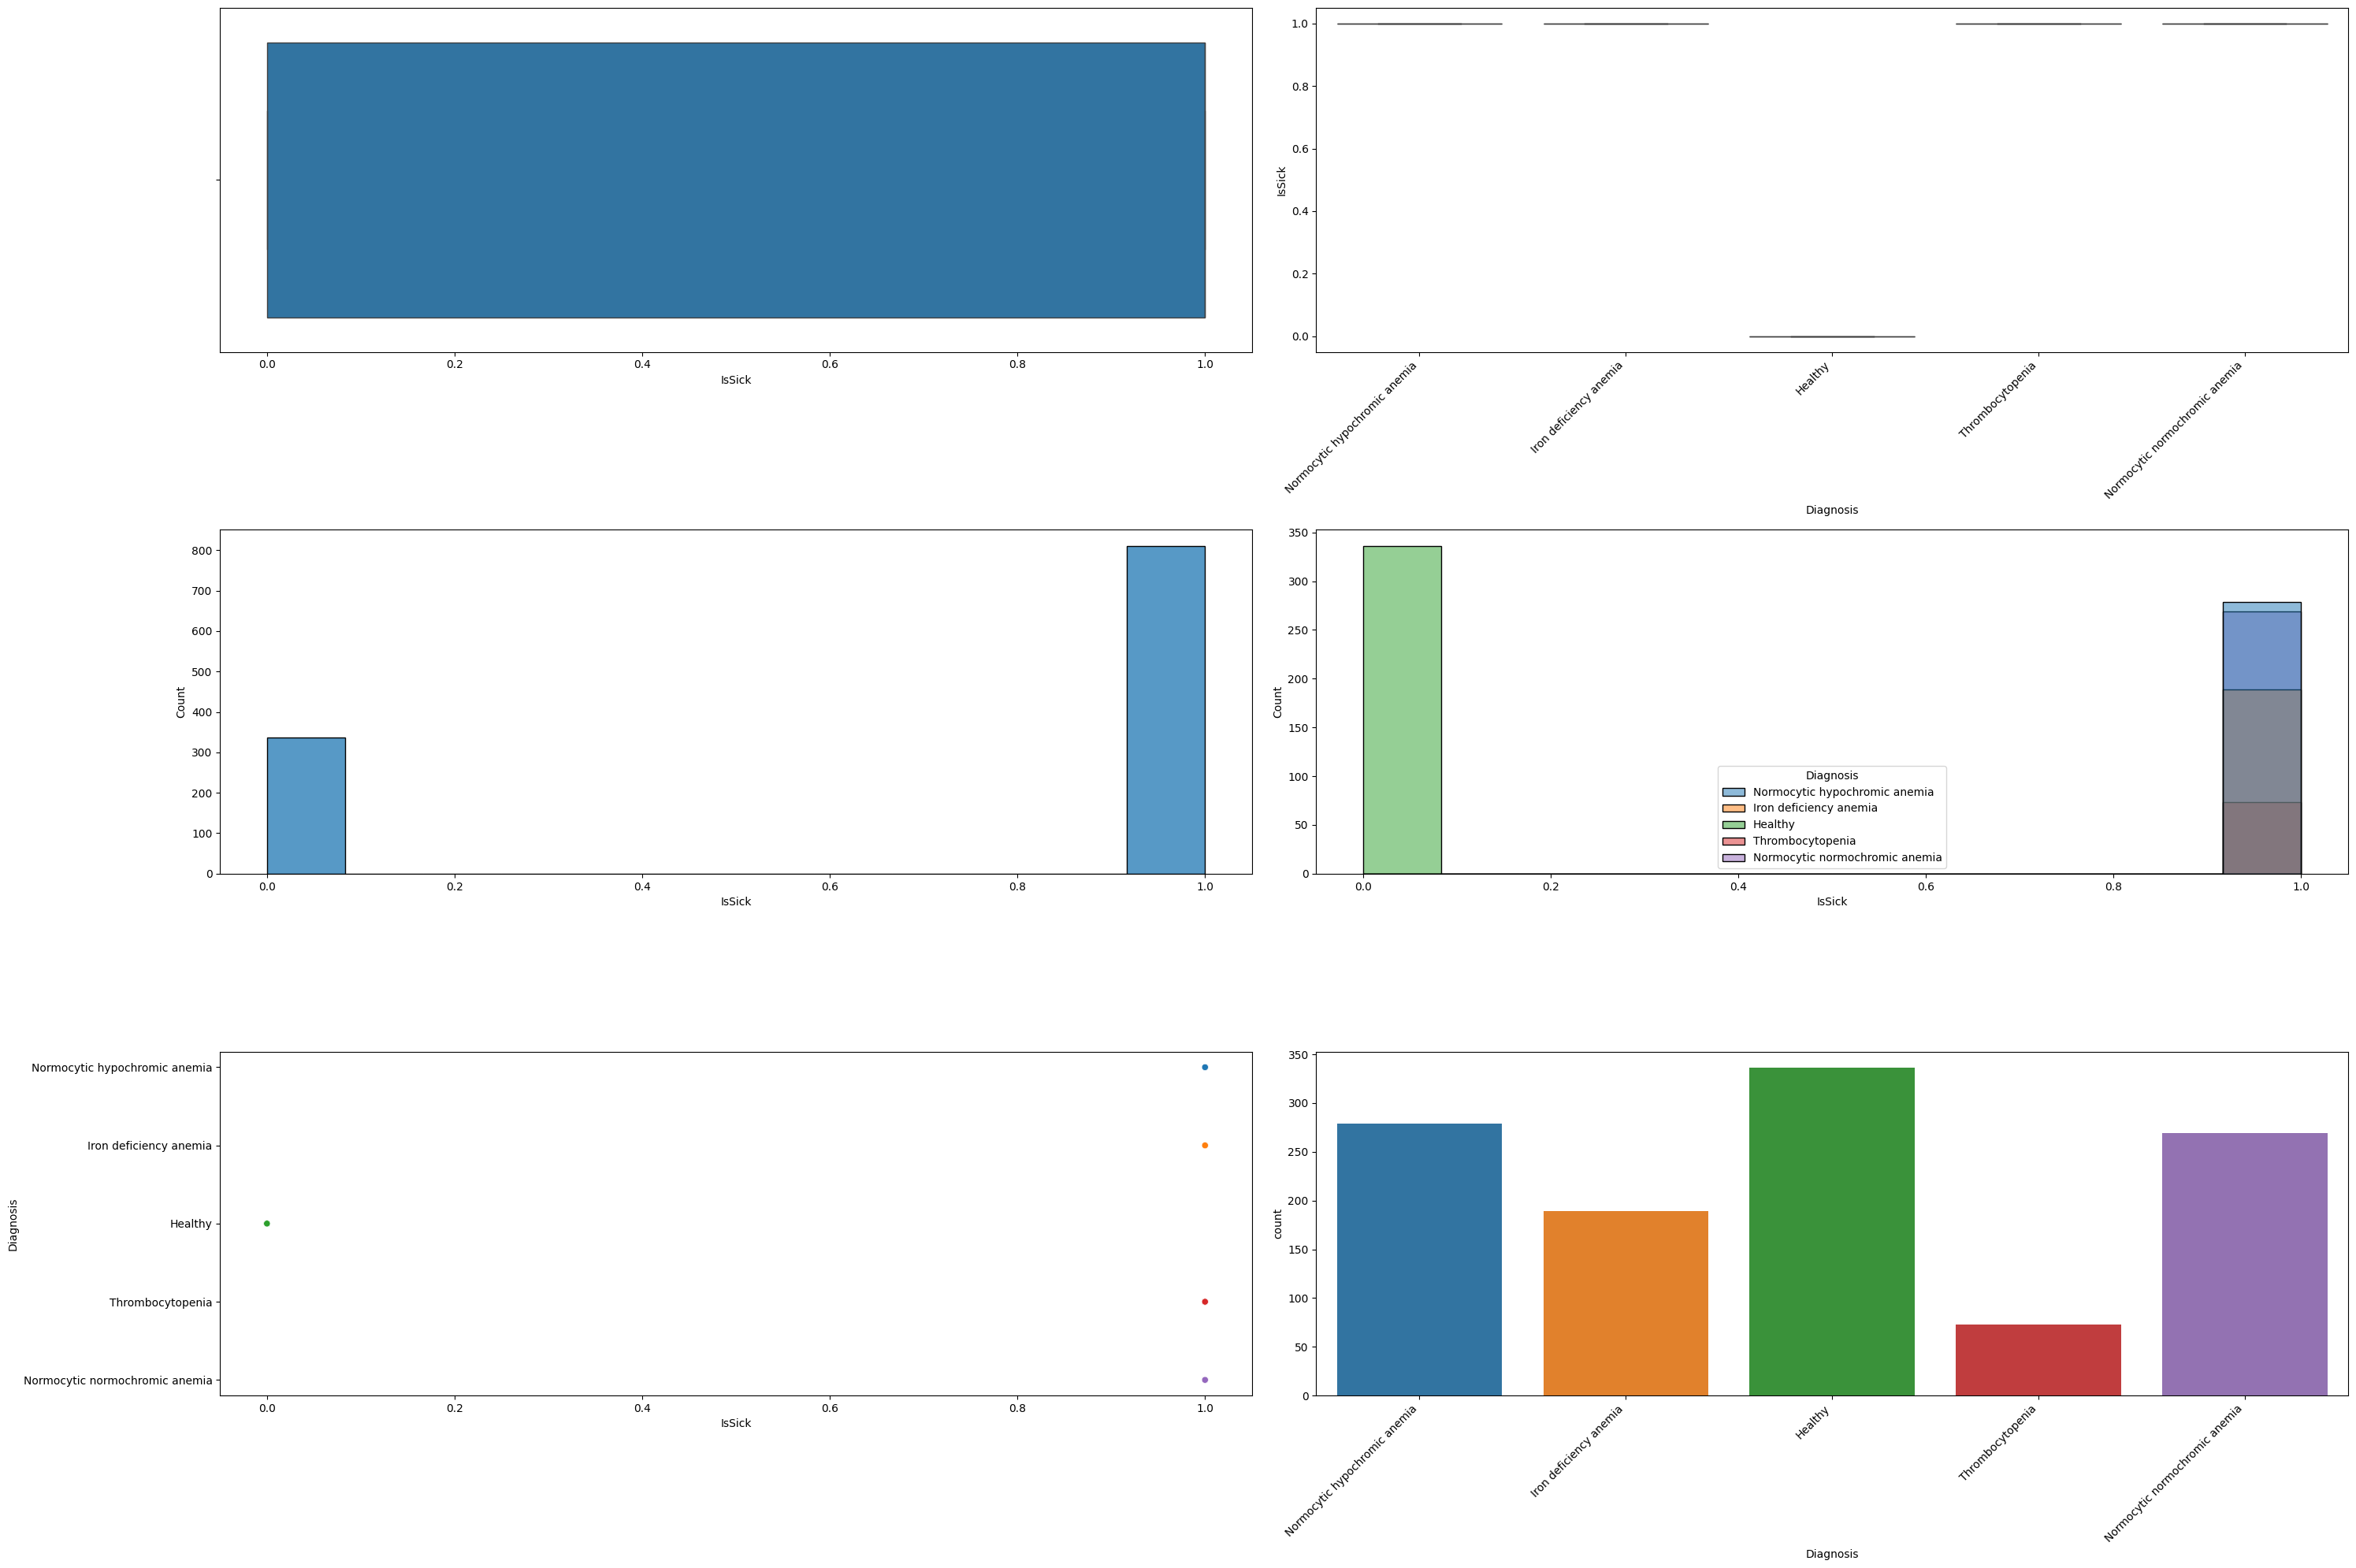

In [258]:
var_quantitatives = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for var in var_quantitatives:
    print(var)
    visualisation_quantitative(var)

In [259]:
#on constate que dans chaque cas nosu avons des valeur extreme qui peuvent être des outliers
#nous allons les supprimer pour ne pas biaiser notre analyse
def remove_outliers(df):
    numeric_columns = df.select_dtypes(include=['float64']).columns
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1

    # Suppression des outliers au-dessus du 3e quartile + 1.5 * IQR et en dessous du 1er quartile - 1.5 * IQR
    df_no_outliers = df[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

    return df_no_outliers

In [260]:
df = remove_outliers(df)
df.shape[0]

970

## Analyse Multivariée

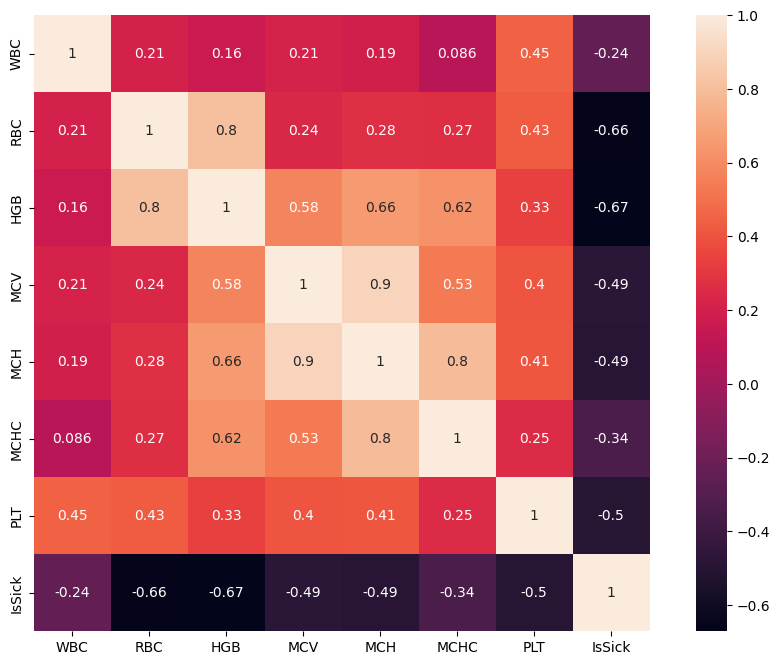

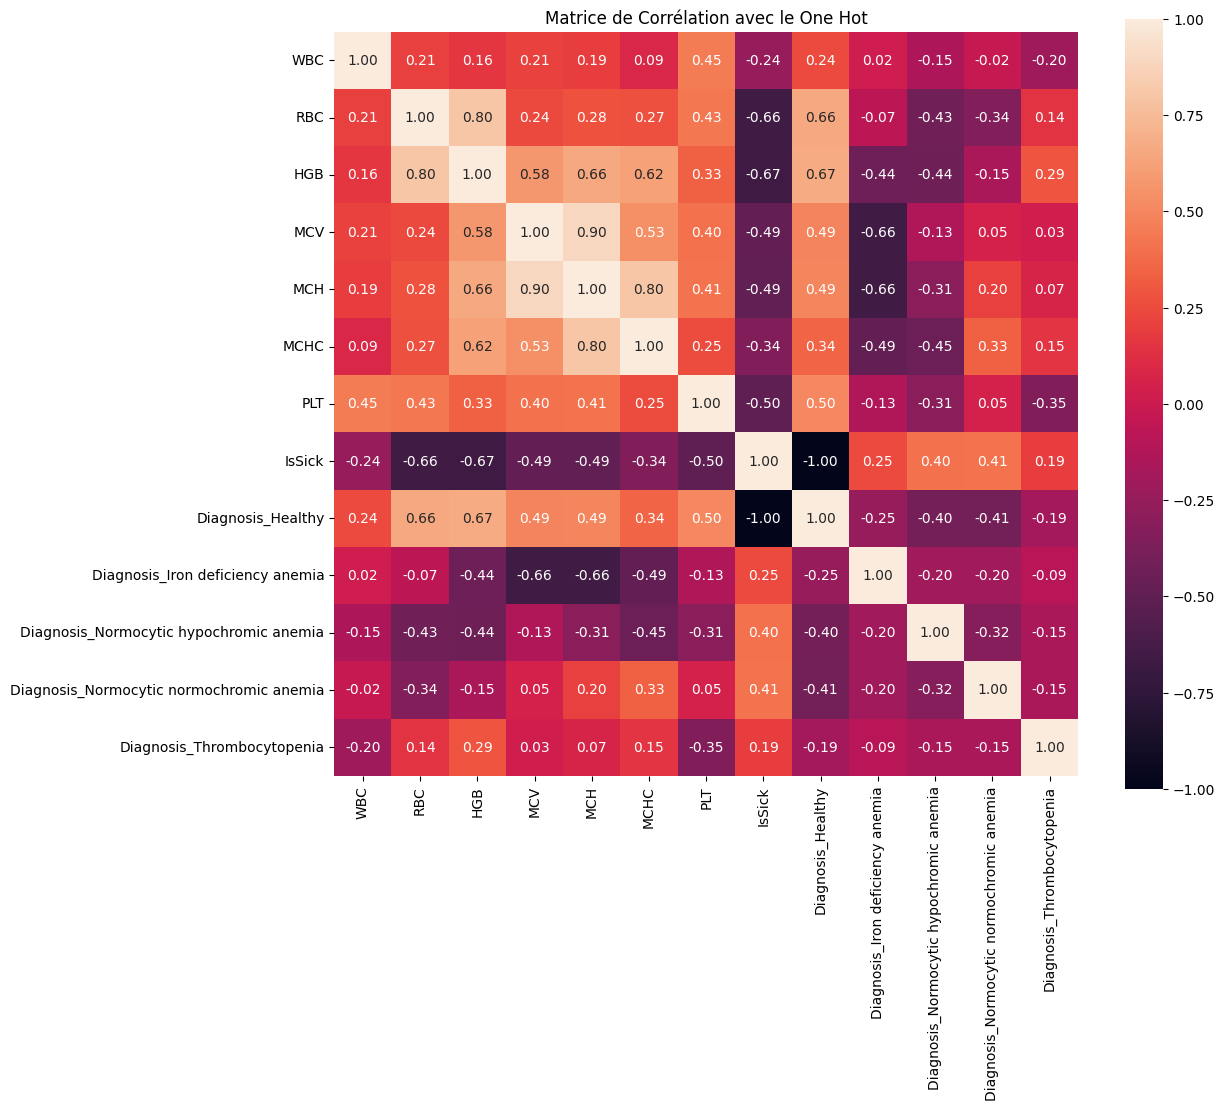

In [261]:
data2 = df.drop(['Diagnosis', 'diagnosis_init'], axis=1)

correration = data2.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correration, square=True, annot=True)
plt.show()

data = df.drop(['diagnosis_init'], axis=1)

# Encoder les étiquettes de Diagnosis
data = pd.get_dummies(data, columns=['Diagnosis'])

# Calculer la matrice de corrélation
correlation_matrix = data.corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, square=True, annot=True, fmt='.2f')
plt.title('Matrice de Corrélation avec le One Hot')
plt.show()

<Figure size 8000x8000 with 0 Axes>

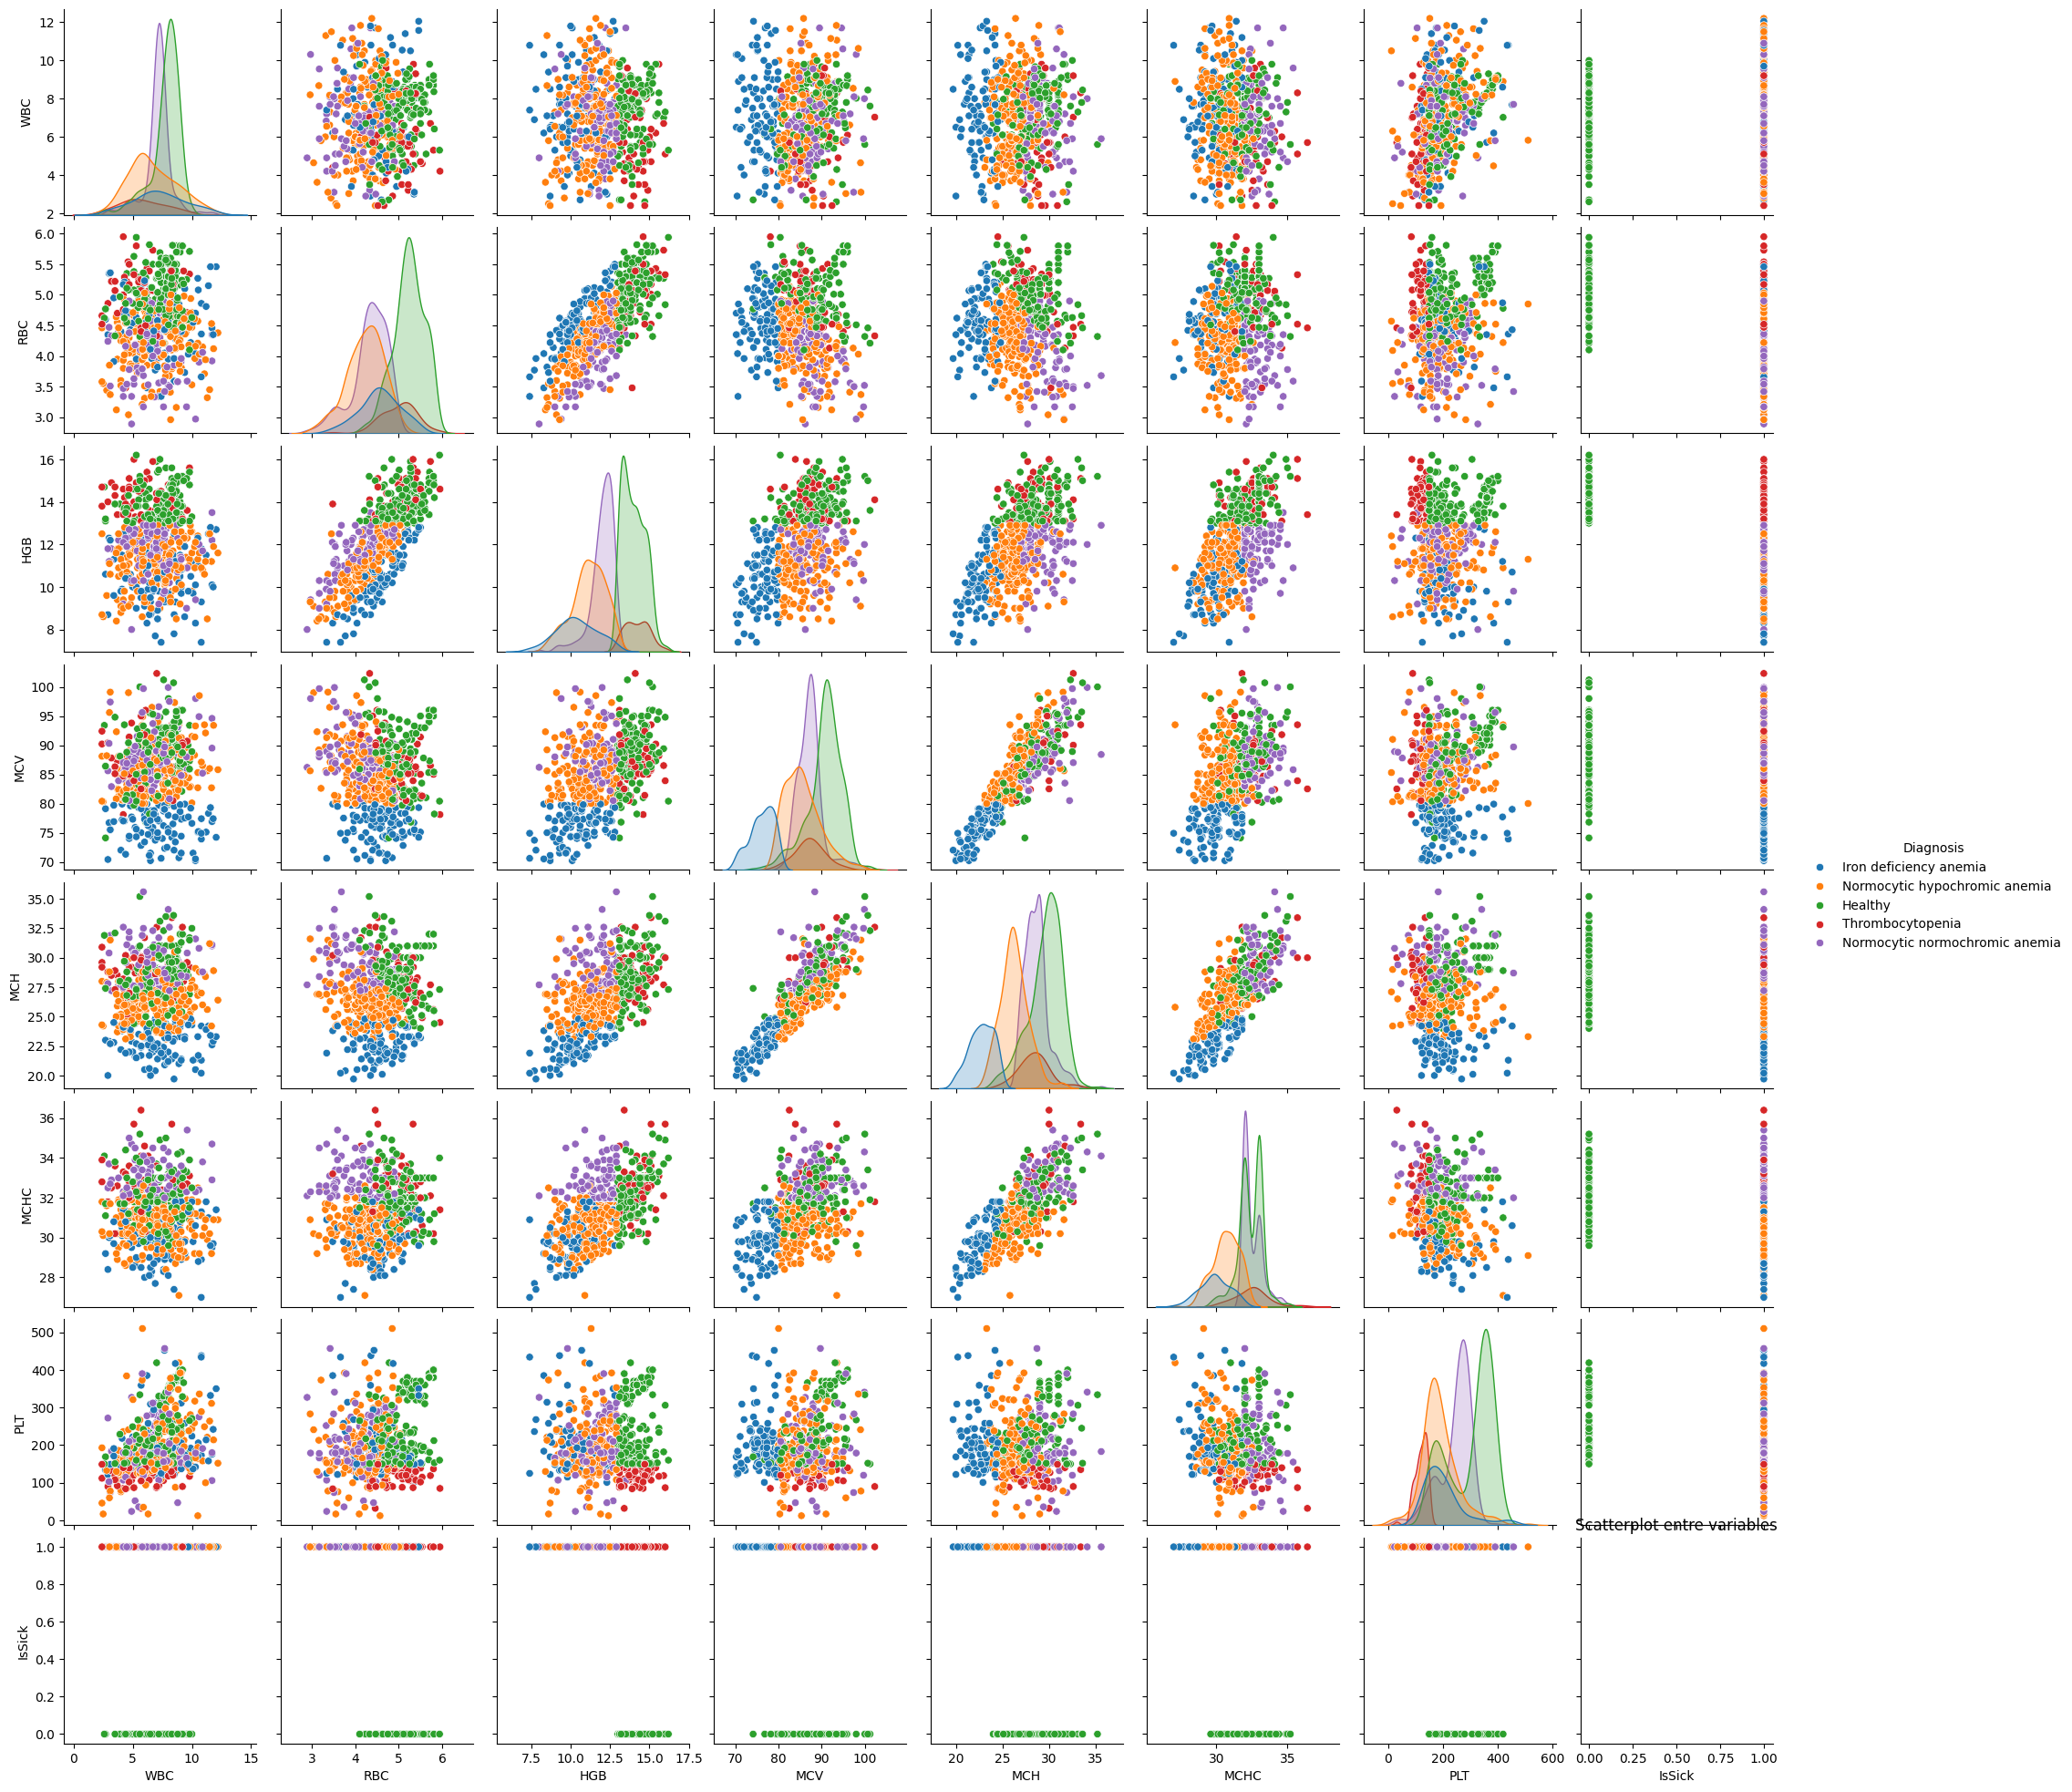

In [262]:
plt.figure(figsize=(80, 80))
sns.pairplot(df, kind='scatter', hue='Diagnosis')
plt.title('Scatterplot entre variables')
plt.show()

## Etude de l'ACP

Pour une Analyse en Composantes Principales (ACP), il est généralement recommandé de standardiser les données plutôt que de simplement les normaliser.

L'ACP est basée sur la variance des données, et si les variables ont des échelles différentes, celles avec une plus grande échelle domineront les composantes principales.

La standardisation rend les variables comparables en termes de variance, ce qui est crucial pour une analyse correcte.

### Comparaison

In [263]:
# Standardisation des données
scaler = StandardScaler()
#drop de la colonne Diagnosis et diagnosis_init
data = df.drop(['Diagnosis', 'diagnosis_init'], axis=1)
data_stand = scaler.fit_transform(data)


#normalisation des données
scaler = MinMaxScaler()
data_norm = scaler.fit_transform(data)


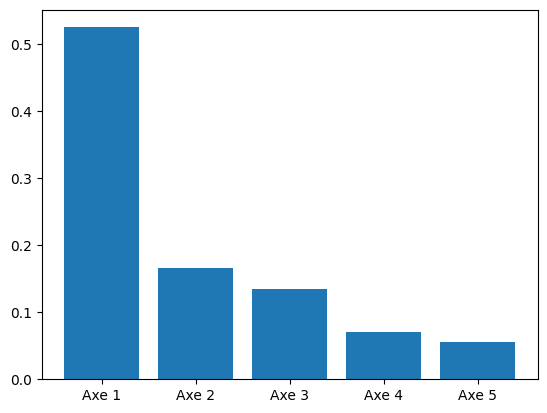

In [264]:
# Analyse en Composantes Principales
cls = PCA(n_components=5)
pcs = cls.fit_transform(data_stand)
plt.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4", "Axe 5"], cls.explained_variance_ratio_)
plt.show()

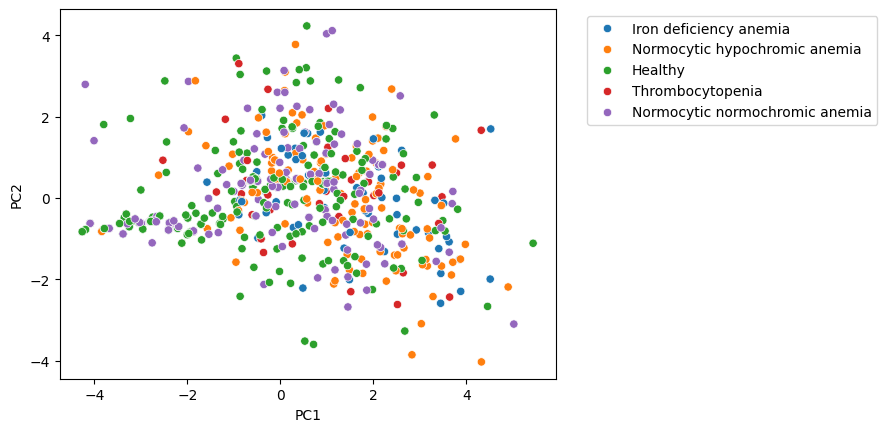

In [265]:
df_Class = pd.DataFrame(data=pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
sns.scatterplot(x="PC1", y="PC2", hue=df.Diagnosis, data=df_Class)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

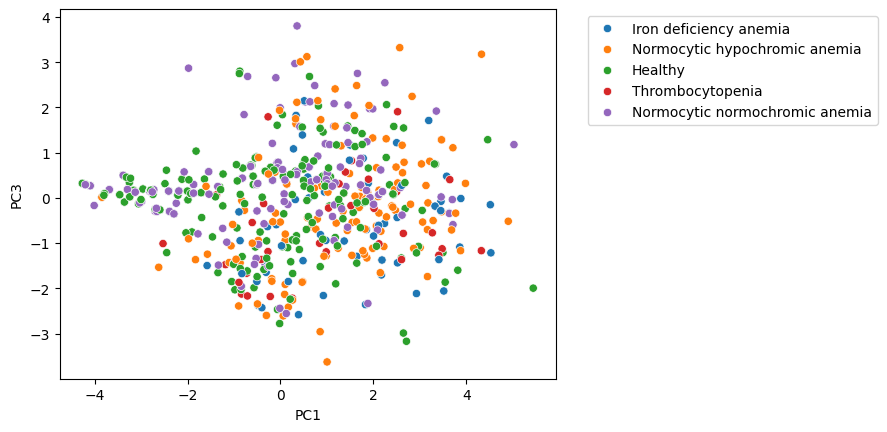

In [266]:
df_Class = pd.DataFrame(data=pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
sns.scatterplot(x="PC1", y="PC3", hue=df.Diagnosis, data=df_Class)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

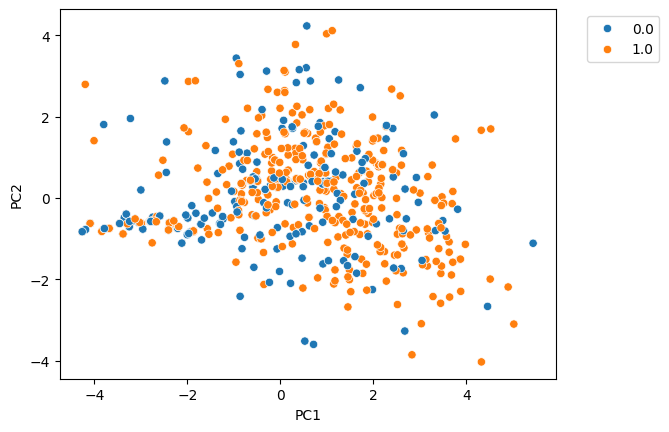

In [267]:
df_Class = pd.DataFrame(data=pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
sns.scatterplot(x="PC1", y="PC2", hue=df.IsSick, data=df_Class)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

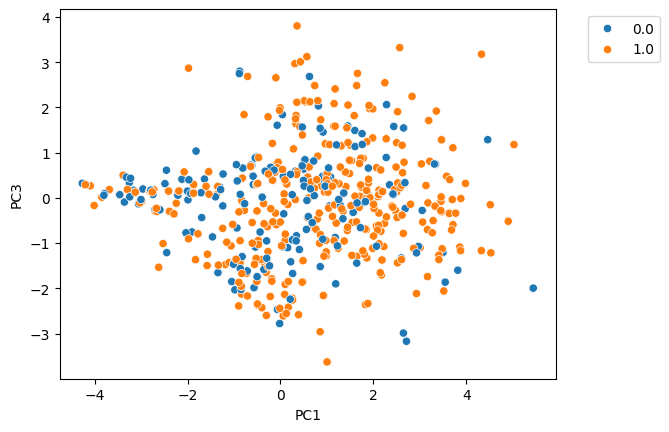

In [268]:
df_Class = pd.DataFrame(data=pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
sns.scatterplot(x="PC1", y="PC3", hue=df.IsSick, data=df_Class)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

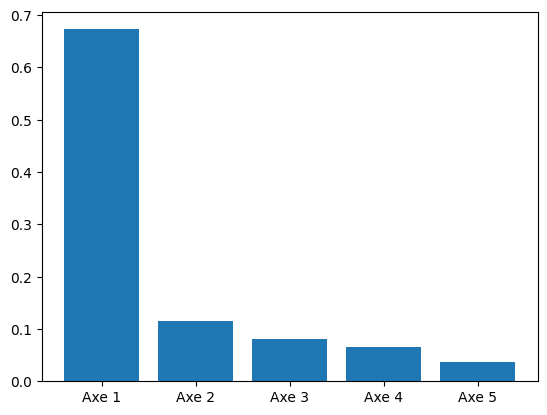

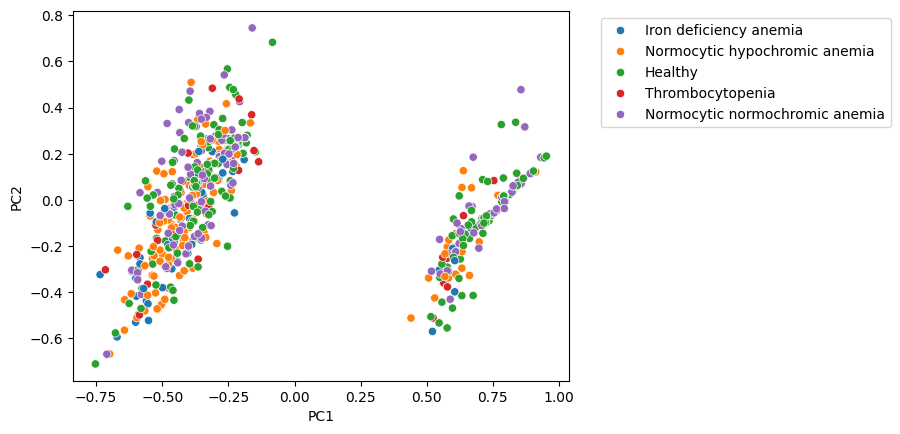

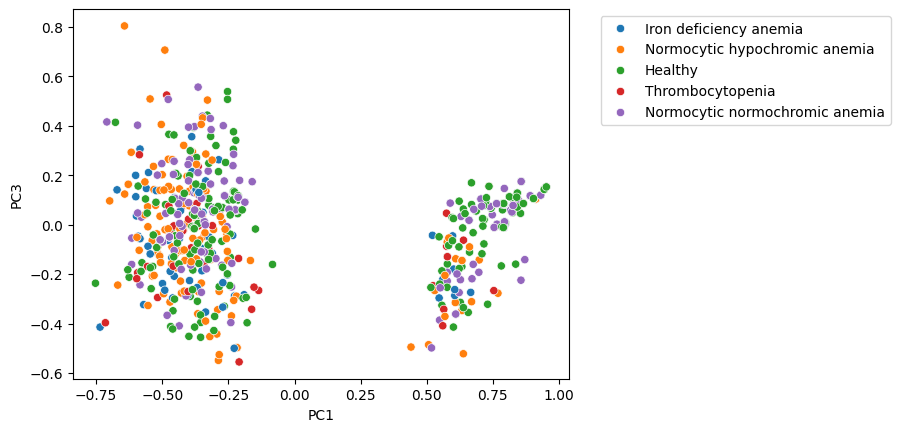

In [269]:
# Analyse en Composantes Principales avec les données normalisées
cls = PCA(n_components=5)
pcs = cls.fit_transform(data_norm)
plt.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4", "Axe 5"], cls.explained_variance_ratio_)
plt.show()

df_Class = pd.DataFrame(data=pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
sns.scatterplot(x="PC1", y="PC2", hue=df.Diagnosis, data=df_Class)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

df_Class = pd.DataFrame(data=pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
sns.scatterplot(x="PC1", y="PC3", hue=df.Diagnosis, data=df_Class)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Conclusion

il est mieux de standardiser les données avant de faire une ACP que de les normaliser.

In [270]:
# #on va quand meme faire du Label Encoding
from sklearn.preprocessing import LabelEncoder

# #instancier l'encodeur
encoder = LabelEncoder()
data_label = df.copy()
# #encoder les colonnes Diagnosis
data_label['Diagnosis'] = encoder.fit_transform(data_label['Diagnosis'])

#afficher les valeurs de la colonne Diagnosis
data_label['Diagnosis'].value_counts()

Diagnosis
0    327
3    240
2    233
1    106
4     64
Name: count, dtype: int64

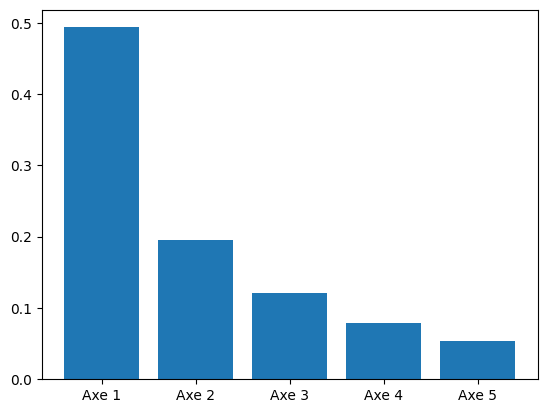

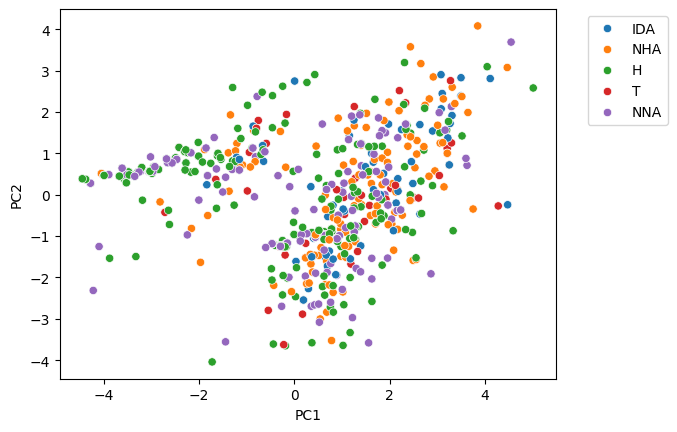

In [271]:
#refaire l'ACP
# Standardisation des données
scaler = StandardScaler()
#drop de la colonne Diagnosis et diagnosis_init
data = data_label.drop(['diagnosis_init'], axis=1)
data_stand = scaler.fit_transform(data)

cls = PCA(n_components=5)
pcs = cls.fit_transform(data_stand)
plt.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4", "Axe 5"], cls.explained_variance_ratio_)
plt.show()

df_Class = pd.DataFrame(data=pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
sns.scatterplot(x="PC1", y="PC2", hue=df.diagnosis_init, data=df_Class)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



bon avec l'acp on vois pas grand chose, on va passer à la classification

In [272]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

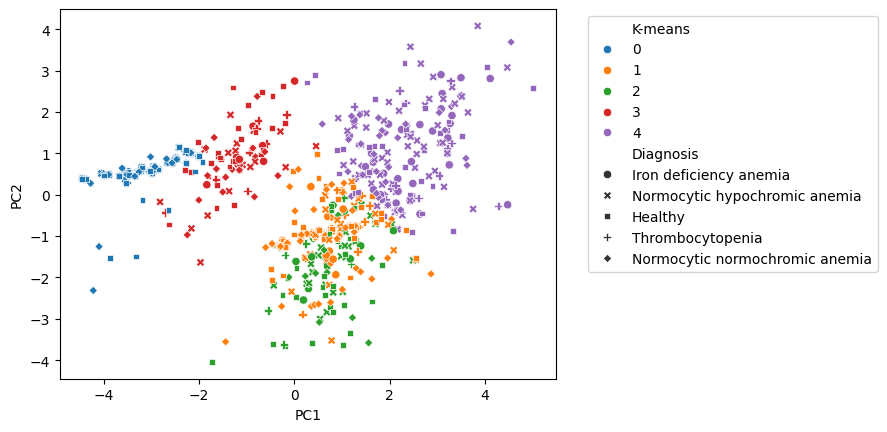

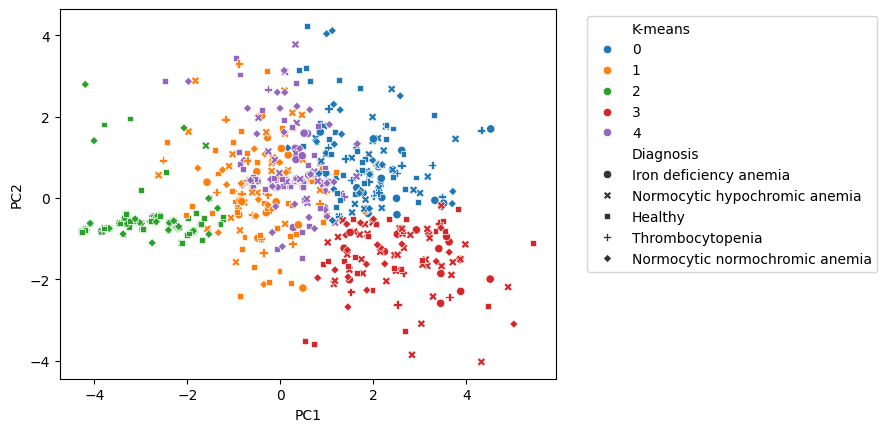

In [273]:
from sklearn.cluster import KMeans
#drop des colonnes non numériques
df_quantitatifs = data_label.drop(['diagnosis_init'], axis=1)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_quantitatifs), columns = df_quantitatifs.columns)

cls1 = KMeans(n_clusters=5, init="random")
cls1.fit(X)

labels = pd.Series(cls1.labels_, name="K-means")
scatterplot_pca(data=X, hue=labels, style=df.Diagnosis)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#meme chose avec df sans label encoding
#drop des colonnes non numériques
df_quantitatifs_nolabel = df.drop(['Diagnosis','diagnosis_init'], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_quantitatifs_nolabel), columns = df_quantitatifs_nolabel.columns)

cls2 = KMeans(n_clusters=5, init="random")
cls2.fit(X)

labels = pd.Series(cls2.labels_, name="K-means")
scatterplot_pca(data=X, hue=labels, style=df.Diagnosis)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [274]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(df['Diagnosis'], cls2.labels_)
print(f"L'indice de Rand ajusté est sans le label encoder : {ari * 100} %")

ari = adjusted_rand_score(df['Diagnosis'], cls1.labels_)
print(f"L'indice de Rand ajusté est avec le label encoder : {ari * 100} %")

L'indice de Rand ajusté est sans le label encoder : 58.86544921594182 %
L'indice de Rand ajusté est avec le label encoder : 53.65906047606986 %


### KNN

In [275]:
def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.

    :param data: Le dataFrame Pandas
    :param clus1: Un premier groupement
    :param clus2: Un deuxième groupement
    :param ax: Les axes sur lesquels dessiner

    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_markerfacecolor()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])

            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], angle=180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    return ax, pca


def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_markerfacecolor()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)

In [276]:
data_knn = data_label.drop(['Diagnosis', 'diagnosis_init'], axis=1)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(data_knn), columns = data_knn.columns)
y = df['Diagnosis']

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
search = GridSearchCV(knn, param_grid={"n_neighbors": range(1, 20)}, cv=5)
search.fit(X_train, y_train)
print(f"Meilleur score : {search.best_score_}")
print(f"Meilleur paramètre : {search.best_params_}")


Meilleur score : 0.9471546732837055
Meilleur paramètre : {'n_neighbors': 5}


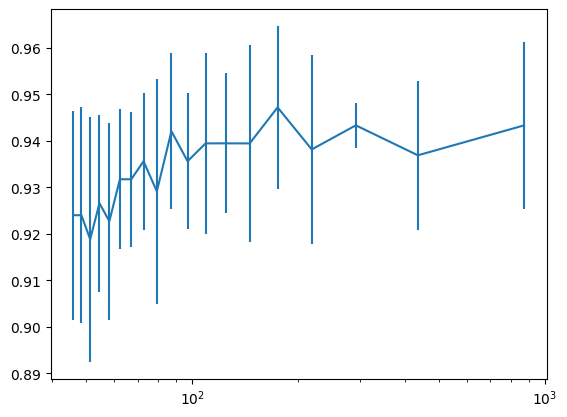

In [277]:
df = pd.DataFrame(
(
dict(n_neighbors=d["n_neighbors"], error=e, std=s)
for d, e, s in zip(
search.cv_results_["params"],
search.cv_results_["mean_test_score"],
search.cv_results_["std_test_score"],
)
)
)
n = 9/10 * len(y)
plt.errorbar(n/df["n_neighbors"], df["error"], yerr=df["std"])
plt.xscale("log")
plt.show()


d:\alexa\Github\projet-sy09\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


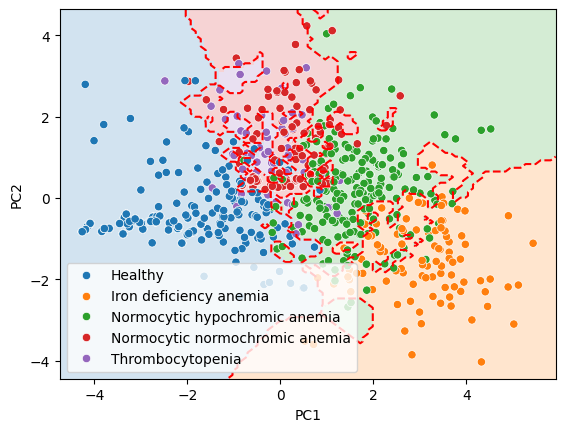

In [278]:
from sklearn.base import BaseEstimator
import matplotlib as mpl

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pcs = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

#estimation du meilleur nombre de voisins
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(pcs, y)

#affichage de la courbe de validation
cls = KNeighborsClassifier(n_neighbors=grid_search.best_params_["n_neighbors"])
cls.fit(pcs, y)
plot_clustering(pcs, y)
add_decision_boundary(cls)
plt.show()